# Office Items Multi-class classification

This notebook generalizes the cats and dogs example to a more complicated classification task with more classes.

## Import the necessary modules and define some helper functions

In [1]:
import importlib

import os
from matplotlib.image import imread
import numpy as np
import matplotlib.pyplot as plt
import time
import logging
from collections import OrderedDict
from datetime import datetime

try:
    import tensorboard  # pylint: disable=import-error
    import tensorflow  # pylint: disable=import-error
    tensorflow.io.gfile = tensorboard.compat.tensorflow_stub.io.gfile
except (ModuleNotFoundError, AttributeError):
    pass

import torch
from torch import nn
import torchnet.meter as tnt
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import nnplot
import operator
import distiller
import distiller.apputils as apputils
from distiller.data_loggers import PythonLogger, TensorBoardLogger

import sys
# modules from subdirectories
sys.path.insert(0, 'models/')
sys.path.insert(1, 'distiller/')
sys.path.insert(2, 'datasets/')

# import models and datasets
from classification import *
mod = importlib.import_module("minivgg")

import ai8x
%matplotlib inline

# Logger handle
msglogger = None

# helper functions
class Args:
    def __init__(conf, act_mode_8bit):
        conf.act_mode_8bit = act_mode_8bit
        conf.truncate_testset = False

def count_params(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params

args = Args(act_mode_8bit=False)

## Define Training Configurations (args)

In [2]:
class Config:
    def __init__(self):
        self.dataset_name = "pass"
        self.dataset_fn = pass_get_datasets
        self.num_classes = 0
        self.model_name = "classifierbackbonenet"
        self.dimensions = (3,128,128)
        self.workers = 4
        self.batch_size = 512
        self.validation_split = 0.0
        self.log_prefix = "SSL"
        self.log_dir = "jupyter_logging"
        self.data_path = "../Datasets/PASS_dataset/"
        self.deterministic = True
        self.print_freq = 50
        self.labels = None
        self.lr = 0.001
        self.num_epochs = 100
        self.qat_policy = {'start_epoch':5, 'weight_bits':8}
        self.device = None
        self.optimizer = None
        self.criterion = None
        self.lr_scheduler = None
        self.args = args
        self.forward = None
        self.is_classification = True
        self.start_epoch = 0

conf = Config()
conf.is_classification = False

## Set up the logger

In [3]:
msglogger = apputils.config_pylogger('logging.conf', conf.log_prefix, conf.log_dir)

# Log various details about the execution environment.
apputils.log_execution_env_state(None, msglogger.logdir)

pylogger = PythonLogger(msglogger, log_1d=True)
all_loggers = [pylogger]

# setup tensorboard
tflogger = TensorBoardLogger(msglogger.logdir, log_1d=True, comment='_'+conf.dataset_name)
tflogger.tblogger.writer.add_text('Command line', "args ---")

# log the training configurations
msglogger.info('dataset_name:%s\ndataset_fn=%s\nnum_classes=%d\nmodel_name=%s\ndimensions=%s\nbatch_size=%d\nvalidation_split=%s\nlr=%f\nnum_epochs=%d\nqat_policy=%s',
                conf.dataset_name,conf.dataset_fn,conf.num_classes,conf.model_name,conf.dimensions,conf.batch_size,conf.validation_split,conf.lr,conf.num_epochs,conf.qat_policy)

Log file for this run: /home/geffencooper/Model_Development/ai8x-training/jupyter_logging/SSL___2022.07.06-174341/SSL___2022.07.06-174341.log
dataset_name:pass
dataset_fn=<function pass_get_datasets at 0x7f22216deca0>
num_classes=0
model_name=classifierbackbonenet
dimensions=(3, 128, 128)
batch_size=512
validation_split=0.0
lr=0.001000
num_epochs=100
qat_policy={'start_epoch': 20, 'weight_bits': 8}



--------------------------------------------------------
Logging to TensorBoard - remember to execute the server:
> tensorboard --logdir='./logs'



## Create and visualize the dataset

../Datasets/PASS_dataset/train


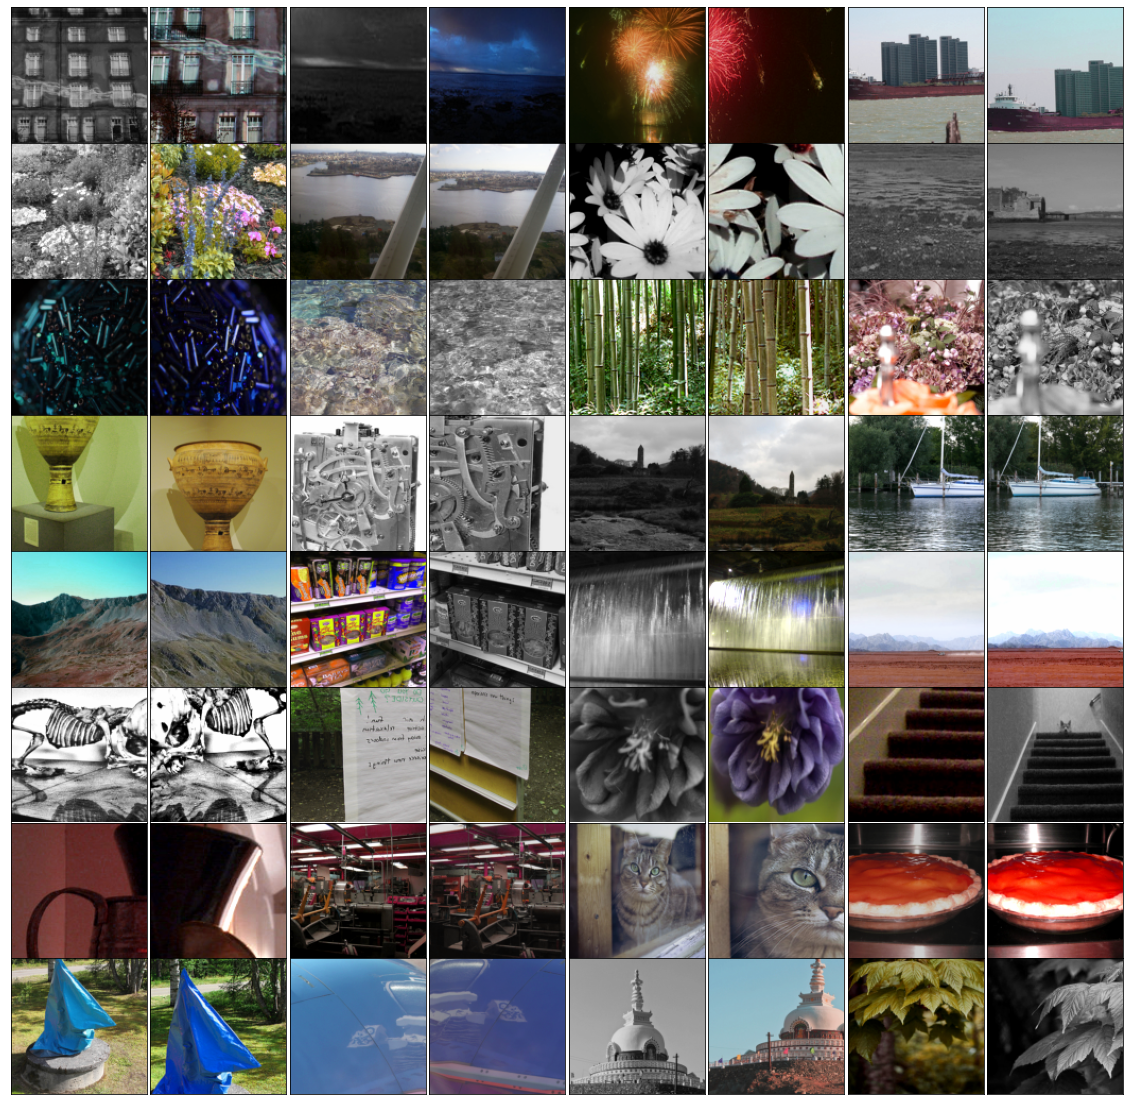

In [4]:
train_set, test_set = conf.dataset_fn((conf.data_path, args), load_train=True, load_test=False)
train_set.visualize_batch()

## Create the data loaders

In [5]:
train_loader, val_loader, test_loader, _ = apputils.get_data_loaders(conf.dataset_fn, (conf.data_path,args), conf.batch_size, conf.workers, conf.validation_split, conf.deterministic,1, 1, 1)

# log dataset information
msglogger.info('Dataset sizes:\n\ttraining=%d\n\tvalidation=%d\n\ttest=%d', len(train_loader.sampler), len(val_loader.sampler), len(test_loader.sampler))
msglogger.info('Augmentations:%s',train_loader.dataset.transform)

Dataset sizes:
	training=149999
	validation=1
	test=1
Augmentations:Compose(
    RandomResizedCrop(size=(128, 128), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
    ColorJitter(brightness=(0.85, 1.15), contrast=(0.85, 1.15), saturation=(0.85, 1.15), hue=(-0.1, 0.1))
    RandomGrayscale(p=0.25)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
)


../Datasets/PASS_dataset/train
../Datasets/PASS_dataset/test


## Set up the device, cuda or cpu

In [6]:
conf.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(conf.device))

Running on device: cuda:0


## Set up the model for training

In [7]:
# set simulation configuration
ai8x.set_device(device=85, simulate=False, round_avg=False)

# create the model
model = mod.ClassifierBackbone()
msglogger.info('model: %s',model)
model = model.to(conf.device)

msglogger.info('Number of Model Params: %d',count_params(model))

# configure tensorboard
dummy_input = torch.randn((1, ) + conf.dimensions)
tflogger.tblogger.writer.add_graph(model.to('cpu'), (dummy_input, ), False)

all_loggers.append(tflogger)
all_tbloggers = [tflogger]

model: ClassifierBackbone(
  (conv1): FusedConv2dReLU(
    (activate): ReLU(inplace=True)
    (op): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (calc_out_shift): OutputShiftSqueeze()
    (calc_weight_scale): One()
    (scale): Scaler()
    (calc_out_scale): OutputScale()
    (quantize_weight): Empty()
    (quantize_bias): Empty()
    (clamp_weight): Empty()
    (clamp_bias): Empty()
    (quantize): Empty()
    (clamp): Clamp()
    (quantize_pool): Empty()
    (clamp_pool): Empty()
  )
  (conv2): FusedConv2dReLU(
    (activate): ReLU(inplace=True)
    (op): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (calc_out_shift): OutputShiftSqueeze()
    (calc_weight_scale): One()
    (scale): Scaler()
    (calc_out_scale): OutputScale()
    (quantize_weight): Empty()
    (quantize_bias): Empty()
    (clamp_weight): Empty()
    (clamp_bias): Empty()
    (quantize): Empty()
    (clamp): Clamp()
    (quantize_pool): Empty()
    (

Configuring device: MAX78000, simulate=False.


Number of Model Params: 287560


## Set up optimizer, loss, and learning schedule

In [8]:
class ContrastiveLoss(nn.Module):
    def __init__(self, batch_size, device,temperature=0.5):
        super().__init__()
        self.batch_size = batch_size
        self.register_buffer("temperature", torch.tensor(temperature))
        self.register_buffer("negatives_mask", (~torch.eye(batch_size * 2, batch_size * 2, dtype=bool)).float())
        self.negatives_mask = self.negatives_mask.to(device)
        self.temperature = self.temperature.to(device)
        self.device = device
            
    def forward(self, emb_i, emb_j):
        """
        emb_i and emb_j are batches of embeddings, where corresponding indices are pairs
        z_i, z_j as per SimCLR paper
        """
        batch_size = self.batch_size
        self.register_buffer("negatives_mask", (~torch.eye(batch_size * 2, batch_size * 2, dtype=bool)).float())
        self.negatives_mask = self.negatives_mask.to(self.device)
        if emb_i.size()[0] != self.batch_size:
            batch_size = emb_i.size()[0]
            self.register_buffer("negatives_mask", (~torch.eye(batch_size * 2, batch_size * 2, dtype=bool)).float())
            self.negatives_mask = self.negatives_mask.to(self.device)

        z_i = F.normalize(emb_i, dim=1)
        z_j = F.normalize(emb_j, dim=1)

        representations = torch.cat([z_i, z_j], dim=0)
        similarity_matrix = F.cosine_similarity(representations.unsqueeze(1), representations.unsqueeze(0), dim=2)
        
        sim_ij = torch.diag(similarity_matrix, batch_size)
        sim_ji = torch.diag(similarity_matrix, -batch_size)
        positives = torch.cat([sim_ij, sim_ji], dim=0)
        
        nominator = torch.exp(positives / self.temperature)
        denominator = self.negatives_mask * torch.exp(similarity_matrix / self.temperature)
    
        loss_partial = -torch.log(nominator / torch.sum(denominator, dim=1))
        loss = torch.sum(loss_partial) / (2 * batch_size)
        # print("CL: ",loss)
        return loss

In [9]:
# optimizer
conf.optimizer = optim.Adam(model.parameters(), lr=conf.lr)
msglogger.info('Optimizer Type: %s', type(conf.optimizer))

# lr schedule
conf.lr_scheduler = optim.lr_scheduler.MultiStepLR(conf.optimizer, milestones=[5, 35,100], gamma=0.5)
msglogger.info("lr_schedule:%s","base: "+str(conf.lr_scheduler.base_lrs)+" milestones: "+str(conf.lr_scheduler.milestones)+ " gamma: "+str(conf.lr_scheduler.gamma))

# loss function
conf.criterion = ContrastiveLoss(conf.batch_size,conf.device,0.5).to(conf.device)
compression_scheduler = distiller.CompressionScheduler(model)

Optimizer Type: <class 'torch.optim.adam.Adam'>
lr_schedule:base: [0.001] milestones: Counter({10: 1, 35: 1, 100: 1}) gamma: 0.5


## Define the forward function

In [10]:
def classifier_forward(model, batch, conf):
    # get the batch items and send to GPU
    input1, input2 = batch[0].to(conf.device), batch[1].to(conf.device)

    # get the output
    return model(input1), model(input2)

conf.forward = classifier_forward

## Validation Function

In [27]:
def validate(data_loader, model, loggers, conf, epoch=-1, tflogger=None):
    """Execute the validation/test loop."""

    # keep track of incorrect predictions
    wrong_samples = None
    wrong_preds = None
    actual_preds = None
    img_names = None

    # store loss stats
    losses = {'objective_loss': tnt.AverageValueMeter()}
    classerr = tnt.ClassErrorMeter(accuracy=True, topk=(1, min(conf.num_classes, 5)))

    # validation set info
    total_samples = len(data_loader.sampler)
    confusion = tnt.ConfusionMeter(conf.num_classes)
    total_steps = (total_samples + conf.batch_size - 1) // conf.batch_size
    msglogger.info('%d samples (%d per mini-batch)', total_samples, conf.batch_size)

    # Switch to evaluation mode
    model.eval()

    class_probs = []
    class_preds = []

    # iterate over the batches in the validation set
    for validation_step, batch in enumerate(data_loader):
        with torch.no_grad():

            output, target = conf.forward(model, batch, conf)
            

            # # get the idxs of the max output
            # pred = output.argmax(dim=1, keepdim=True)
            
            # wrong_idx = (pred != target.view_as(pred)).nonzero()[:, 0] # get wrong predictions
            
            # if validation_step == 0:
            #     wrong_samples = inputs[wrong_idx]
            #     wrong_preds = pred[wrong_idx]
            #     actual_preds = target.view_as(pred)[wrong_idx]
            #     img_names = [names[i.item()] for i in wrong_idx] #names[wrong_idx]
            # else:
            #     wrong_samples = torch.cat((wrong_samples,inputs[wrong_idx]),0)
            #     wrong_preds = torch.cat((wrong_preds,pred[wrong_idx]),0)
            #     actual_preds = torch.cat((actual_preds,target.view_as(pred)[wrong_idx]),0)
            #     img_names.extend([names[i.item()] for i in wrong_idx])

            # compute loss
            loss = conf.criterion(output, target)

            # measure accuracy and record loss
            losses['objective_loss'].add(loss.item())
            classerr.add(output.data, target)
            confusion.add(output.data, target)

            # store prediction stats
            steps_completed = (validation_step+1)
            if steps_completed % conf.print_freq == 0 or steps_completed == total_steps:
                class_probs_batch = [torch.nn.functional.softmax(el, dim=0) for el in output]
                _, class_preds_batch = torch.max(output, 1)
                class_probs.append(class_probs_batch)
                class_preds.append(class_preds_batch)

                stats = (
                    '',
                    OrderedDict([('Loss', losses['objective_loss'].mean),
                                 ('Top1', classerr.value(1))])
                )
                if conf.num_classes > 5:
                    stats[1]['Top5'] = classerr.value(5)

                distiller.log_training_progress(stats, None, epoch, steps_completed, total_steps, conf.print_freq, loggers)

    if conf.num_classes > 5:
        msglogger.info('==> Top1: %.3f    Top5: %.3f    Loss: %.3f\n', classerr.value()[0], classerr.value()[1], losses['objective_loss'].mean)
    else:
        msglogger.info('==> Top1: %.3f    Loss: %.3f\n', classerr.value()[0], losses['objective_loss'].mean)

    msglogger.info('==> Confusion:\n%s\n', str(confusion.value()))
    if tflogger is not None:
        cf = nnplot.confusion_matrix(confusion.value(), conf.labels)
        tflogger.tblogger.writer.add_image('Validation/ConfusionMatrix', cf, epoch,
                                            dataformats='HWC')
    # if epoch > 0:
    #     data_loader.dataset.viz_mispredict(wrong_samples,wrong_preds,actual_preds,img_names)
    return classerr.value(1), classerr.value(min(conf.num_classes, 5)), losses['objective_loss'].mean

## Training Function

In [28]:
def train(train_loader, val_loader, test_loader, model, conf):

    # store model history across epochs
    perf_scores_history = []
    model = model.to(conf.device)

    # start the clock
    tic = datetime.now()

    # =============================== training loop =====================================
    for epoch in range(conf.start_epoch, conf.num_epochs):
        # check if need to switch to QAT
        if epoch > 0 and epoch == conf.qat_policy['start_epoch']:
            print('QAT is starting!')
            # Fuse the BN parameters into conv layers before Quantization Aware Training (QAT)
            ai8x.fuse_bn_layers(model)

            # Switch model from unquantized to quantized for QAT
            ai8x.initiate_qat(model, conf.qat_policy)

            # Model is re-transferred to GPU in case parameters were added
            model.to(conf.device)

            # Empty the performance scores list for QAT operation
            perf_scores_history = []
            conf.model_name = f'{conf.model_name}_qat'

        # store loss and training stats
        losses = {'objective_loss': tnt.AverageValueMeter()}
        classerr = tnt.ClassErrorMeter(accuracy=True, topk=(1, min(conf.num_classes, 5)))

        # logging stats
        total_samples = len(train_loader.sampler)
        steps_per_epoch = (total_samples + conf.batch_size - 1) // conf.batch_size
        msglogger.info('Training epoch: %d samples (%d per mini-batch)', total_samples, conf.batch_size)

        # Switch to train mode
        model.train()
        acc_stats = []

        # =================================== batch loop ===================================
        for train_step, batch in enumerate(train_loader):
            output, target = conf.forward(model,batch,conf)
       
            loss = conf.criterion(output, target)

            # on the last batch store the stats for the epoch
            if conf.is_classification:
                if train_step >= len(train_loader)-2:
                    classerr.add(output.data, target)
                    acc_stats.append([classerr.value(1), classerr.value(min(conf.num_classes, 5))])

            # add the loss for each batch
            losses["objective_loss"].add(loss.item())

            # reset the optimizer
            conf.optimizer.zero_grad()

            # backwards pass and parameter update
            loss.backward()
            conf.optimizer.step()

            # track batch stats
            steps_completed = (train_step+1)

            # log stats every 10 batches
            if steps_completed % conf.print_freq == 0 or steps_completed == steps_per_epoch:
                if conf.is_classification:
                    # Log some statistics
                    errs = OrderedDict()
                    if classerr.n != 0:
                        errs['Top1'] = classerr.value(1)
                        if conf.num_classes > 5:
                            errs['Top5'] = classerr.value(5)
                    else:
                        errs['Top1'] = None
                        errs['Top5'] = None

                    stats_dict = OrderedDict()
                    for loss_name, meter in losses.items():
                        stats_dict[loss_name] = meter.mean
                    stats_dict.update(errs)
                    
                    stats_dict['LR'] = conf.optimizer.param_groups[0]['lr']
                    stats = ('Performance/Training/', stats_dict)
                    params = None
                    distiller.log_training_progress(stats,params,epoch,steps_completed,steps_per_epoch,conf.print_freq,all_loggers)
                else:
                    stats_dict = OrderedDict()
                    for loss_name, meter in losses.items():
                        stats_dict[loss_name] = meter.mean
                    stats_dict['LR'] = conf.optimizer.param_groups[0]['lr']
                    stats = ('Performance/Training/', stats_dict)
                    params = None
                    distiller.log_training_progress(stats,params,epoch,steps_completed,steps_per_epoch,conf.print_freq,all_loggers)


        # ============================= validation =======================
        if conf.is_classification:
            msglogger.info('--- validate (epoch=%d)-----------', epoch)
            top1, top5, vloss = validate(val_loader, model, [pylogger], conf, epoch, tflogger)

            # store validation stats
            stats = ('Performance/Validation/', OrderedDict([('Loss', vloss), ('Top1', top1)]))
            if conf.num_classes > 5:
                stats[1]['Top5'] = top5

            distiller.log_training_progress(stats, None, epoch, steps_completed=0, total_steps=1,
                                                    log_freq=1, loggers=all_tbloggers)

            perf_scores_history.append(distiller.MutableNamedTuple({'top1': top1, 'top5': top5,
                                                                    'epoch': epoch}))
            # Keep perf_scores_history sorted from best to worst
            # Sort by top1 as main sort key, then sort by top5 and epoch
            perf_scores_history.sort(key=operator.attrgetter('top1', 'top5', 'epoch'),reverse=True)
            for score in perf_scores_history[:1]:
                if conf.num_classes > 5:
                    msglogger.info('==> Best [Top1: %.3f   Top5: %.3f  on epoch: %d]',
                                    score.top1, score.top5,score.epoch)
                else:
                    msglogger.info('==> Best [Top1: %.3f on epoch: %d]',
                                    score.top1, score.epoch)

            # Save the checkpoint
            is_best = epoch == perf_scores_history[0].epoch
            checkpoint_extras = {'current_top1': top1,
                                'best_top1': perf_scores_history[0].top1,
                                'best_epoch': perf_scores_history[0].epoch}

            apputils.save_checkpoint(epoch, conf.model_name, model, optimizer=conf.optimizer,
                                        scheduler=compression_scheduler, extras=checkpoint_extras,
                                        is_best=is_best, name=conf.model_name,
                                        dir=msglogger.logdir)
        else:
            checkpoint_extras = {'epoch': epoch}

            apputils.save_checkpoint(epoch, conf.model_name, model, optimizer=conf.optimizer,
                                        scheduler=compression_scheduler, extras=checkpoint_extras,
                                        is_best=False, name=conf.model_name,
                                        dir=msglogger.logdir)
        conf.lr_scheduler.step()

    # ========================= test ============================
    if conf.is_classification:
        top1, top5, losses = validate(val_loader, model, [pylogger], conf, epoch, tflogger)
        msglogger.info('==> Test Set [Top1: %.3f   Top5: %.3f  on test set]', top1, top5)
    msglogger.info('Training time: %s', datetime.now() - tic)

## Train the model

In [23]:
# mode = mod.ClassifierBackbone()
# mode, compression_schedule, optimize, start_epoc = apputils.load_checkpoint(mode, "jupyter_logging/SSL___2022.07.06-174341/classifierbackbonenet_checkpoint.pth.tar", model_device=conf.device)
# ai8x.update_model(model)
conf.start_epoch = 19

In [26]:
train(train_loader, val_loader, test_loader, model,conf)

Training epoch: 149999 samples (512 per mini-batch)
Epoch: [19][   50/  293]    objective_loss 6.019766    LR 0.000500    
Epoch: [19][  100/  293]    objective_loss 5.934000    LR 0.000500    
Epoch: [19][  150/  293]    objective_loss 5.882026    LR 0.000500    
Epoch: [19][  200/  293]    objective_loss 5.847641    LR 0.000500    
Epoch: [19][  250/  293]    objective_loss 5.821308    LR 0.000500    
Epoch: [19][  293/  293]    objective_loss 5.802801    LR 0.000500    
Saving checkpoint to: jupyter_logging/SSL___2022.07.06-174341/classifierbackbonenet_checkpoint.pth.tar
Training epoch: 149999 samples (512 per mini-batch)


QAT is starting!


Epoch: [20][   50/  293]    objective_loss 5.682070    LR 0.000500    
Epoch: [20][  100/  293]    objective_loss 5.678157    LR 0.000500    
Epoch: [20][  150/  293]    objective_loss 5.674192    LR 0.000500    
Epoch: [20][  200/  293]    objective_loss 5.670597    LR 0.000500    
Epoch: [20][  250/  293]    objective_loss 5.666991    LR 0.000500    
Epoch: [20][  293/  293]    objective_loss 5.664681    LR 0.000500    
Saving checkpoint to: jupyter_logging/SSL___2022.07.06-174341/classifierbackbonenet_checkpoint.pth.tar
Training epoch: 149999 samples (512 per mini-batch)
Epoch: [21][   50/  293]    objective_loss 5.650263    LR 0.000500    
Epoch: [21][  100/  293]    objective_loss 5.652865    LR 0.000500    
Epoch: [21][  150/  293]    objective_loss 5.650220    LR 0.000500    
Epoch: [21][  200/  293]    objective_loss 5.648983    LR 0.000500    
Epoch: [21][  250/  293]    objective_loss 5.647758    LR 0.000500    
Epoch: [21][  293/  293]    objective_loss 5.647606    LR 0.0005

KeyboardInterrupt: 

## Fine-tune to Office5

In [1]:
import importlib

import os
from matplotlib.image import imread
import numpy as np
import matplotlib.pyplot as plt
import time
import logging
from collections import OrderedDict
from datetime import datetime

try:
    import tensorboard  # pylint: disable=import-error
    import tensorflow  # pylint: disable=import-error
    tensorflow.io.gfile = tensorboard.compat.tensorflow_stub.io.gfile
except (ModuleNotFoundError, AttributeError):
    pass

import torch
from torch import nn
import torchnet.meter as tnt
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import nnplot
import operator
import distiller
import distiller.apputils as apputils
from distiller.data_loggers import PythonLogger, TensorBoardLogger

import sys
# modules from subdirectories
sys.path.insert(0, 'models/')
sys.path.insert(1, 'distiller/')
sys.path.insert(2, 'datasets/')

# import models and datasets
from classification import *
mod = importlib.import_module("minivgg")

import ai8x
%matplotlib inline

# Logger handle
msglogger = None

# helper functions
class Args:
    def __init__(conf, act_mode_8bit):
        conf.act_mode_8bit = act_mode_8bit
        conf.truncate_testset = False

def count_params(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params

args = Args(act_mode_8bit=False)

In [2]:
class Config:
    def __init__(self):
        self.dataset_name = "office5"
        self.dataset_fn = office5_get_datasets
        self.num_classes = 5
        self.model_name = "classifierbackbonenet"
        self.dimensions = (3,128,128)
        self.workers = 4
        self.batch_size = 32
        self.validation_split = 0.1
        self.log_prefix = "finetune_office5"
        self.log_dir = "jupyter_logging"
        self.data_path = "../Datasets/office5/"
        self.deterministic = True
        self.print_freq = 50
        self.labels = ('back_pack', 'keyboard','laptop_computer','mug','pen')
        self.lr = 0.001
        self.num_epochs = 20
        self.qat_policy = {'start_epoch':5, 'weight_bits':8}
        self.device = None
        self.optimizer = None
        self.criterion = None
        self.lr_scheduler = None
        self.args = args
        self.forward = None
        self.is_classification = True
        self.start_epoch = 0

conf = Config()

In [3]:
msglogger = apputils.config_pylogger('logging.conf', conf.log_prefix, conf.log_dir)

# Log various details about the execution environment.
apputils.log_execution_env_state(None, msglogger.logdir)

pylogger = PythonLogger(msglogger, log_1d=True)
all_loggers = [pylogger]

# setup tensorboard
tflogger = TensorBoardLogger(msglogger.logdir, log_1d=True, comment='_'+conf.dataset_name)
tflogger.tblogger.writer.add_text('Command line', "args ---")

# log the training configurations
msglogger.info('dataset_name:%s\ndataset_fn=%s\nnum_classes=%d\nmodel_name=%s\ndimensions=%s\nbatch_size=%d\nvalidation_split=%s\nlr=%f\nnum_epochs=%d\nqat_policy=%s',
                conf.dataset_name,conf.dataset_fn,conf.num_classes,conf.model_name,conf.dimensions,conf.batch_size,conf.validation_split,conf.lr,conf.num_epochs,conf.qat_policy)

Log file for this run: /home/geffencooper/Model_Development/ai8x-training/jupyter_logging/finetune_office5___2022.07.07-103201/finetune_office5___2022.07.07-103201.log
dataset_name:office5
dataset_fn=<function office5_get_datasets at 0x7f4018ccec10>
num_classes=5
model_name=classifierbackbonenet
dimensions=(3, 128, 128)
batch_size=32
validation_split=0.1
lr=0.001000
num_epochs=20
qat_policy={'start_epoch': 5, 'weight_bits': 8}



--------------------------------------------------------
Logging to TensorBoard - remember to execute the server:
> tensorboard --logdir='./logs'



../Datasets/office5/train
{'keyboard': 0, 'pen': 1, 'back_pack': 2, 'mug': 3, 'laptop_computer': 4}


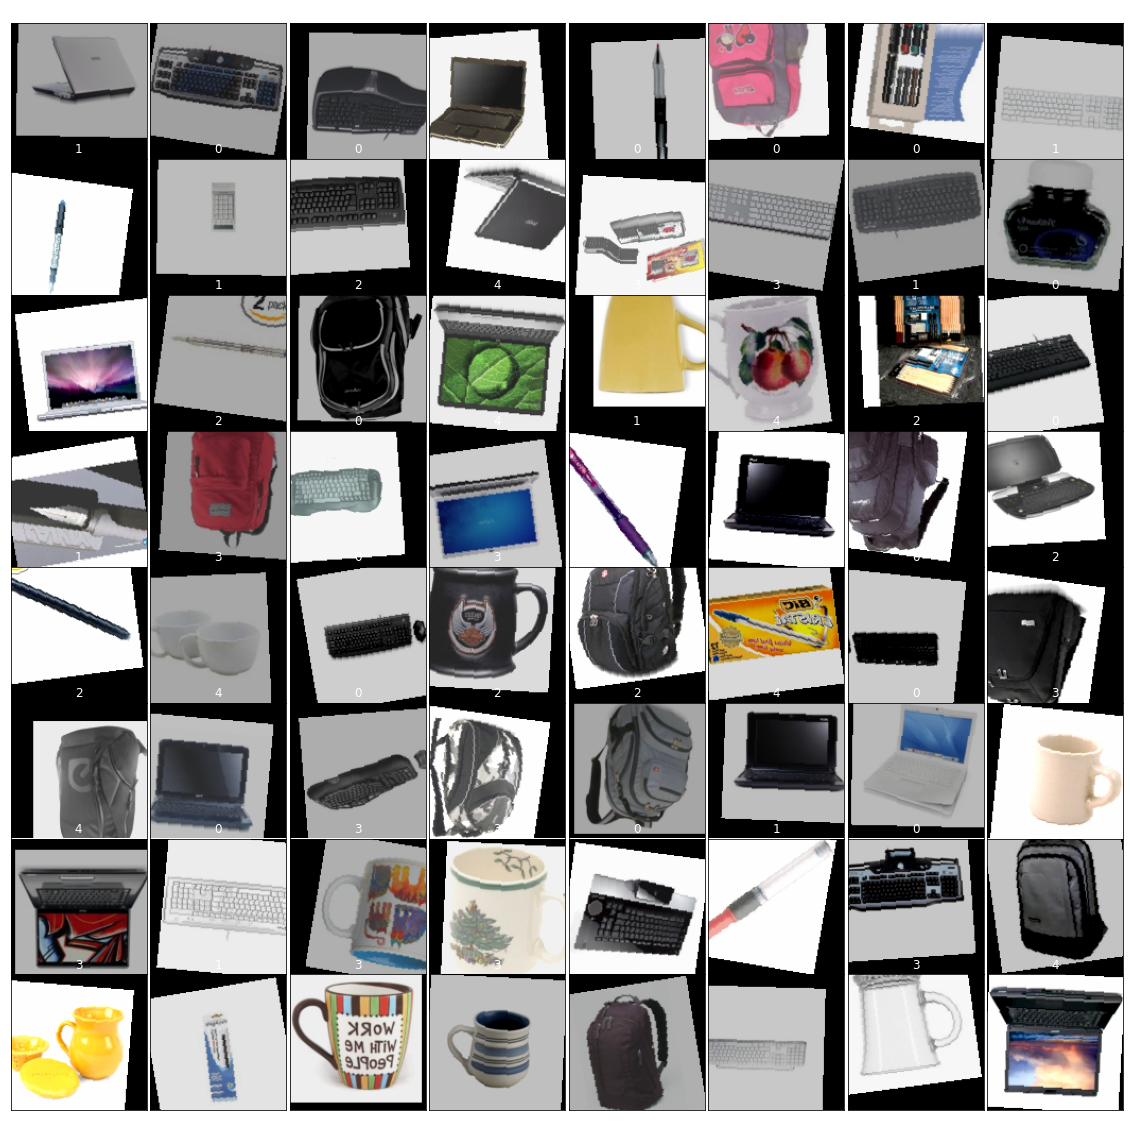

In [4]:
train_set, test_set = conf.dataset_fn((conf.data_path, args), load_train=True, load_test=False)
train_set.visualize_batch()

In [5]:
train_loader, val_loader, test_loader, _ = apputils.get_data_loaders(conf.dataset_fn, (conf.data_path,args), conf.batch_size, conf.workers, conf.validation_split, conf.deterministic,1, 1, 1)

# log dataset information
msglogger.info('Dataset sizes:\n\ttraining=%d\n\tvalidation=%d\n\ttest=%d', len(train_loader.sampler), len(val_loader.sampler), len(test_loader.sampler))
msglogger.info('Augmentations:%s',train_loader.dataset.transform)

Dataset sizes:
	training=388
	validation=43
	test=50
Augmentations:Compose(
    Resize(size=(128, 128), interpolation=bilinear)
    ColorJitter(brightness=(0.65, 1.35), contrast=(0.65, 1.35), saturation=(0.65, 1.35), hue=None)
    RandomAffine(degrees=[-10.0, 10.0], translate=(0.2, 0.2))
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    ToTensor()
)


../Datasets/office5/train
{'keyboard': 0, 'pen': 1, 'back_pack': 2, 'mug': 3, 'laptop_computer': 4}
../Datasets/office5/test
{'keyboard': 0, 'pen': 1, 'back_pack': 2, 'mug': 3, 'laptop_computer': 4}


In [6]:
conf.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(conf.device))

Running on device: cuda:0


In [8]:
# set simulation configuration
ai8x.set_device(device=85, simulate=False, round_avg=False)

# create the model
model = mod.OfficeClassifier()
msglogger.info('model: %s',model)
model = model.to(conf.device)

msglogger.info('Number of Model Params: %d',count_params(model))

# configure tensorboard
dummy_input = torch.randn((1, ) + conf.dimensions)
tflogger.tblogger.writer.add_graph(model.to('cpu'), (dummy_input, ), False)

all_loggers.append(tflogger)
all_tbloggers = [tflogger]

=> loading checkpoint jupyter_logging/SSL___2022.07.06-174341/classifierbackbonenet_checkpoint.pth.tar
=> Checkpoint contents:
+----------------------+-------------+-----------------------+
| Key                  | Type        | Value                 |
|----------------------+-------------+-----------------------|
| arch                 | str         | classifierbackbonenet |
| compression_sched    | dict        |                       |
| epoch                | int         | 29                    |
| extras               | dict        |                       |
| optimizer_state_dict | dict        |                       |
| optimizer_type       | type        | Adam                  |
| state_dict           | OrderedDict |                       |
+----------------------+-------------+-----------------------+

=> Checkpoint['extras'] contents:
+-------+--------+---------+
| Key   | Type   |   Value |
|-------+--------+---------|
| epoch | int    |      29 |
+-------+--------+---------+


Configuring device: MAX78000, simulate=False.


Number of Model Params: 287213


In [9]:
# optimizer
conf.optimizer = optim.Adam(model.parameters(), lr=conf.lr)
msglogger.info('Optimizer Type: %s', type(conf.optimizer))

# lr schedule
conf.lr_scheduler = optim.lr_scheduler.MultiStepLR(conf.optimizer, milestones=[5, 35,100], gamma=0.5)
msglogger.info("lr_schedule:%s","base: "+str(conf.lr_scheduler.base_lrs)+" milestones: "+str(conf.lr_scheduler.milestones)+ " gamma: "+str(conf.lr_scheduler.gamma))

# loss function
conf.criterion = nn.CrossEntropyLoss().to(conf.device)
compression_scheduler = distiller.CompressionScheduler(model)

Optimizer Type: <class 'torch.optim.adam.Adam'>
lr_schedule:base: [0.001] milestones: Counter({5: 1, 35: 1, 100: 1}) gamma: 0.5


In [ ]:
def classifier_forward(model, batch, conf):
    # get the batch items and send to GPU
    inputs, target = batch[0].to(conf.device), batch[1].to(conf.device)

    # get the output
    return model(inputs), target

conf.forward = classifier_forward

## Visualize Embeddings

In [38]:
def viz_embeddings(test_batch_path,conf,batch_size,trained_model_path,model,to_pred=False):
    _, test_set = conf.dataset_fn((test_batch_path, conf.args), load_train=False, load_test=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

    # load the trained model
    ai8x.set_device(device=85, simulate=False, round_avg=False)                      
    checkpoint = torch.load(trained_model_path, map_location=lambda storage, loc: storage)
    ai8x.fuse_bn_layers(model)
    model = apputils.load_lean_checkpoint(model, trained_model_path, model_device=conf.device)
    ai8x.update_model(model)
    model = model.to(conf.device)

    # get a batch of data
    (batch_imgs, batch_labels) = next(iter(test_loader))
    batch_imgs,batch_labels = batch_imgs.to(conf.device), batch_labels.to(conf.device)

    # register forward hook to get embedding output
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook

    # get the activations
    model.eval()
    model.fc1.register_forward_hook(get_activation('fc1'))
    preds = model(batch_imgs)
    embds = activation['fc1']

    # get the labels
    batch_label_strings = []
    for idx,label in enumerate(batch_labels):
        batch_label_strings.append(test_set.label_dict[label.item()])

    # log to tensorboard
    tflogger.tblogger.writer.add_embedding(
            embds.to('cpu'),
            metadata=batch_label_strings,
            label_img=batch_imgs.to('cpu'),
            global_step=0
        )

    if to_pred:
        print("batch acc: ",np.sum(np.argmax(preds.to('cpu').detach().numpy(),axis=1) == batch_labels.to('cpu').detach().numpy())/len(batch_imgs))

### 1: Visualize cat and dog clusters from dataset and from camera  
* for the dataset images, set the test_batch_path to ../Datasets/test_batch_d/
* for the camera images, set the test_batch_path to ../Datasets/test_batch/  

We see that for this particular batch of images we get **68.75%** on the **camera** batch and **93.75%** on the **dataset** batch. When visualizing the output embeddings of the CNN encoder we also see that the dataset batch clusters better

In [15]:
# init the model
model = mod.CatsAndDogsClassifier()

# create the embeddings
viz_embeddings("../Datasets/test_batch/",conf,64,"jupyter_logging/high_acc_b32_long_train___2022.06.24-175831/catdognet_qat_best.pth.tar",model,True)

=> loading checkpoint jupyter_logging/high_acc_b32_long_train___2022.06.24-175831/catdognet_qat_best.pth.tar
=> Checkpoint contents:
+----------------------+-------------+-----------+
| Key                  | Type        | Value     |
|----------------------+-------------+-----------|
| arch                 | str         | catdognet |
| compression_sched    | dict        |           |
| epoch                | int         | 1425      |
| extras               | dict        |           |
| optimizer_state_dict | dict        |           |
| optimizer_type       | type        | Adam      |
| state_dict           | OrderedDict |           |
+----------------------+-------------+-----------+

=> Checkpoint['extras'] contents:
+--------------+--------+---------+
| Key          | Type   |   Value |
|--------------+--------+---------|
| best_epoch   | int    | 1425    |
| best_top1    | float  |   94.95 |
| current_top1 | float  |   94.95 |
+--------------+--------+---------+

Loaded compression

../Datasets/test_batch/test
{'dogs': 0, 'cats': 1}
Configuring device: MAX78000, simulate=False.
batch acc:  0.6875


### 2: Visualize difference in domains
* path is ../Datasets/test_batch4  

From the embeddings we can see that there is a shift between the domains, e.g. all the cat images should cluster together rather than form independent clusters based on the domain

In [16]:
# init the model
model = mod.CatsAndDogsClassifier()

# create the embeddings
viz_embeddings("../Datasets/test_batch4/",conf,128,"jupyter_logging/high_acc_b32_long_train___2022.06.24-175831/catdognet_qat_best.pth.tar",model,False)

=> loading checkpoint jupyter_logging/high_acc_b32_long_train___2022.06.24-175831/catdognet_qat_best.pth.tar
=> Checkpoint contents:
+----------------------+-------------+-----------+
| Key                  | Type        | Value     |
|----------------------+-------------+-----------|
| arch                 | str         | catdognet |
| compression_sched    | dict        |           |
| epoch                | int         | 1425      |
| extras               | dict        |           |
| optimizer_state_dict | dict        |           |
| optimizer_type       | type        | Adam      |
| state_dict           | OrderedDict |           |
+----------------------+-------------+-----------+

=> Checkpoint['extras'] contents:
+--------------+--------+---------+
| Key          | Type   |   Value |
|--------------+--------+---------|
| best_epoch   | int    | 1425    |
| best_top1    | float  |   94.95 |
| current_top1 | float  |   94.95 |
+--------------+--------+---------+

Loaded compression

../Datasets/test_batch4/test
{'cat_dataset': 0, 'dog_camera': 1, 'dog_dataset': 2, 'cat_camera': 3}
Configuring device: MAX78000, simulate=False.


## Quantize the model

You must change the kernel to execute within the ai8x-synthesis virtual environment

In [1]:
%load_ext autoreload
%autoreload 2
%run ../ai8x-synthesis/quantize.py jupyter_logging/dcd_train_adv___2022.07.06-141737/catdogclassifier_qat_best.pth.tar jupyter_logging/dcd_train_adv___2022.07.06-141737/catdogclassifier_qat_best-q.pth.tar --device MAX78000 -v

Configuring device: MAX78000
Converting checkpoint file jupyter_logging/dcd_train_adv___2022.07.06-141737/catdogclassifier_qat_best.pth.tar to jupyter_logging/dcd_train_adv___2022.07.06-141737/catdogclassifier_qat_best-q.pth.tar

Model keys (state_dict):
conv1.output_shift, conv1.weight_bits, conv1.bias_bits, conv1.quantize_activation, conv1.adjust_output_shift, conv1.shift_quantile, conv1.op.weight, conv2.output_shift, conv2.weight_bits, conv2.bias_bits, conv2.quantize_activation, conv2.adjust_output_shift, conv2.shift_quantile, conv2.op.weight, conv3.output_shift, conv3.weight_bits, conv3.bias_bits, conv3.quantize_activation, conv3.adjust_output_shift, conv3.shift_quantile, conv3.op.weight, conv4.output_shift, conv4.weight_bits, conv4.bias_bits, conv4.quantize_activation, conv4.adjust_output_shift, conv4.shift_quantile, conv4.op.weight, conv4.op.bias, conv5.output_shift, conv5.weight_bits, conv5.bias_bits, conv5.quantize_activation, conv5.adjust_output_shift, conv5.shift_quantile, co

## Evaluate Quantized Model

Change virtual environment back to ai8x-training

In [1]:
import importlib

import os
from matplotlib.image import imread
import numpy as np
import matplotlib.pyplot as plt
import time
import logging
from collections import OrderedDict

try:
    import tensorboard  # pylint: disable=import-error
    import tensorflow  # pylint: disable=import-error
    tensorflow.io.gfile = tensorboard.compat.tensorflow_stub.io.gfile
except (ModuleNotFoundError, AttributeError):
    pass

import torch
from torch import nn
import torchnet.meter as tnt
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import nnplot
import operator
import distiller
import distiller.apputils as apputils
from distiller.data_loggers import PythonLogger, TensorBoardLogger

import sys
sys.path.insert(0, 'models/')
sys.path.insert(1, 'distiller/')
sys.path.insert(2, 'datasets/')

from classification import *

mod = importlib.import_module("minivgg")

import ai8x
%matplotlib inline

# Logger handle
msglogger = None

class Args:
    def __init__(self, act_mode_8bit):
        self.act_mode_8bit = act_mode_8bit
        self.truncate_testset = False

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
load_model_path = 'jupyter_logging/dcd_train_adv___2022.07.06-141737/catdogclassifier_qat_best-q.pth.tar'

# Change this path to match file system layout
data_path = "../Datasets/cats_and_dogs/"

ai8x.set_device(device=85, simulate=True, round_avg=False)

model = mod.CatsAndDogsClassifier()
                          
checkpoint = torch.load(load_model_path, map_location=lambda storage, loc: storage)
ai8x.fuse_bn_layers(model)
model = apputils.load_lean_checkpoint(model, load_model_path, model_device=device)
ai8x.update_model(model)
model = model.to(device)

Configuring device: MAX78000, simulate=True.


In [3]:
args = Args(act_mode_8bit=True)

_, test_set = cats_and_dogs_get_datasets((data_path, args), load_train=True, load_test=True)
test_dataloader = DataLoader(test_set, batch_size=128, shuffle=False)

../Datasets/cats_and_dogs/train
{'dogs': 0, 'cats': 1}
../Datasets/cats_and_dogs/test
{'dogs': 0, 'cats': 1}


In [5]:
model.eval()
acc = 0.
acc_weight = 0
with torch.no_grad():
    for image, label in test_dataloader:
        image = image.to(device)
        label = label.type(torch.long).to(device)
        model_out = model(image)
        label_out = torch.argmax(model_out, dim=1)

        tp = torch.sum(label_out == label)
        acc_batch = (tp / label_out.numel()).detach().item()
        acc += label_out.shape[0] * acc_batch
        acc_weight += label_out.shape[0]

    total_acc = 100 * (acc / acc_weight)
print(f'Quantized accuracy: {total_acc:.2f}%')

Quantized accuracy: 94.40%


## Create a sample image

In [10]:
for image, label,name in test_dataloader:
    break
im_sample = (image[0].detach().cpu().numpy()).astype(np.int64)
np.save('../ai8x-synthesis/tests/sample_cats_and_dogs.npy', im_sample)

## Model Synthesis

In [4]:
%cd ../ai8x-synthesis/
%run ai8xize.py --verbose --log --test-dir sdk/Examples/MAX78000/CNN --prefix cats_and_dogs_DA --checkpoint-file ../ai8x-training/jupyter_logging/dcd_train_adv___2022.07.06-141737/catdogclassifier_qat_best-q.pth.tar --config-file networks/cats_and_dogs.yaml --device MAX78000 --softmax --compact-data --mexpress --timer 0 --fifo --display-checkpoint

Creating network...  ━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  17%

# Now we do domain adaptation to improve the results

## Reload the modules

In [42]:
import importlib

import os
from matplotlib.image import imread
import numpy as np
import matplotlib.pyplot as plt
import time
import logging
from collections import OrderedDict
from datetime import datetime

try:
    import tensorboard  # pylint: disable=import-error
    import tensorflow  # pylint: disable=import-error
    tensorflow.io.gfile = tensorboard.compat.tensorflow_stub.io.gfile
except (ModuleNotFoundError, AttributeError):
    pass

import torch
from torch import nn
import torchnet.meter as tnt
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import nnplot
import operator
import distiller
import distiller.apputils as apputils
from distiller.data_loggers import PythonLogger, TensorBoardLogger

import sys
# modules from subdirectories
sys.path.insert(0, 'models/')
sys.path.insert(1, 'distiller/')
sys.path.insert(2, 'datasets/')

# import models and datasets
from classification import *
mod = importlib.import_module("minivgg")

import ai8x
%matplotlib inline

# Logger handle
msglogger = None

# helper functions
class Args:
    def __init__(self, act_mode_8bit):
        self.act_mode_8bit = act_mode_8bit
        self.truncate_testset = False

def count_params(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params

args = Args(act_mode_8bit=False)

## New Training Parameters for discriminator

In [44]:
class Config:
    def __init__(self):
        self.dataset_name = "pairs"
        self.dataset_fn = pairs_get_datasets
        self.num_classes = 4
        self.model_name = "catdogdcdnet"
        self.dimensions = (1,128)
        self.workers = 4
        self.batch_size = 32
        self.validation_split = 0.1
        self.log_prefix = "dcd_train"
        self.log_dir = "jupyter_logging"
        self.source_data_path = "../Datasets/cats_and_dogs/"
        self.target_data_path = "../Datasets/cats_and_dogs_target/"
        self.deterministic = True
        self.print_freq = 100
        self.labels = ('G1', 'G2', 'G3', 'G4')
        self.lr = 0.001
        self.num_epochs = 32
        self.qat_policy = {'start_epoch':32, 'weight_bits':8}
        self.device = None
        self.optimizer = None
        self.criterion = None
        self.lr_scheduler = None
        self.args = args
        self.forward = None
        self.enc_model = None
        self.enc_output = None

conf = Config()

## Set up the logger

In [45]:
msglogger = apputils.config_pylogger('logging.conf', conf.log_prefix, conf.log_dir)

# Log various details about the execution environment.
apputils.log_execution_env_state(None, msglogger.logdir)

pylogger = PythonLogger(msglogger, log_1d=True)
all_loggers = [pylogger]

# setup tensorboard
tflogger = TensorBoardLogger(msglogger.logdir, log_1d=True, comment='_'+conf.dataset_name)
tflogger.tblogger.writer.add_text('Command line', "args ---")

# log the training configurations
msglogger.info('dataset_name:%s\ndataset_fn=%s\nnum_classes=%d\nmodel_name=%s\ndimensions=%s\nbatch_size=%d\nvalidation_split=%s\nlr=%f\nnum_epochs=%d\nqat_policy=%s',
                conf.dataset_name,conf.dataset_fn,conf.num_classes,conf.model_name,conf.dimensions,conf.batch_size,conf.validation_split,conf.lr,conf.num_epochs,conf.qat_policy)

Log file for this run: /home/geffencooper/Model_Development/ai8x-training/jupyter_logging/dcd_train___2022.07.05-141916/dcd_train___2022.07.05-141916.log
dataset_name:pairs
dataset_fn=<function pairs_get_datasets at 0x7fcf0edd5790>
num_classes=4
model_name=catdogdcdnet
dimensions=(1, 128)
batch_size=32
validation_split=0.1
lr=0.001000
num_epochs=32
qat_policy={'start_epoch': 32, 'weight_bits': 8}



--------------------------------------------------------
Logging to TensorBoard - remember to execute the server:
> tensorboard --logdir='./logs'



## Create and Visualize the dataset

../Datasets/cats_and_dogs/train
../Datasets/cats_and_dogs_target/train
../Datasets/cats_and_dogs/train
{'dogs': 0, 'cats': 1}
../Datasets/cats_and_dogs_target/train
{'dogs': 0, 'cats': 1}
../Datasets/cats_and_dogs/test
../Datasets/cats_and_dogs_target/test
../Datasets/cats_and_dogs/test
{'dogs': 0, 'cats': 1}
../Datasets/cats_and_dogs_target/test
{'dogs': 0, 'cats': 1}


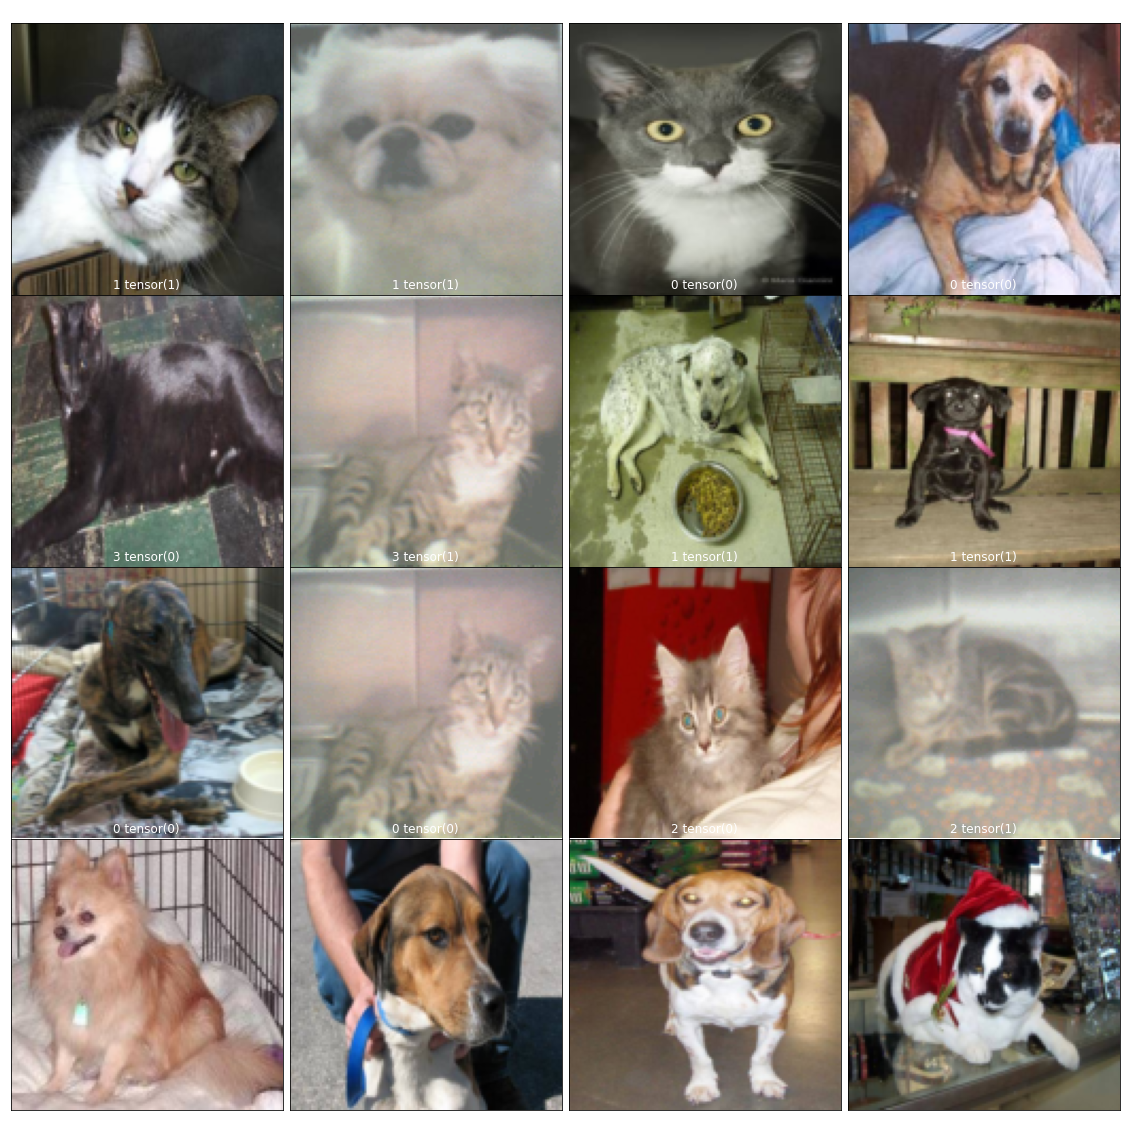

In [46]:
train_set, test_set = conf.dataset_fn(((conf.source_data_path,conf.target_data_path), args), load_train=True, load_test=True)
train_set.visualize_batch()

## Create the dataloaders

In [47]:
train_loader, val_loader, test_loader, _ = apputils.get_data_loaders(conf.dataset_fn, ((conf.source_data_path,conf.target_data_path), args), conf.batch_size, conf.workers, conf.validation_split, conf.deterministic,1, 1, 1)

# log dataset information
msglogger.info('Dataset sizes:\n\ttraining=%d\n\tvalidation=%d\n\ttest=%d', len(train_loader.sampler), len(val_loader.sampler), len(test_loader.sampler))
msglogger.info('Augmentations:%s',train_loader.dataset.transform)

../Datasets/cats_and_dogs/train
../Datasets/cats_and_dogs_target/train
../Datasets/cats_and_dogs/train
{'dogs': 0, 'cats': 1}
../Datasets/cats_and_dogs_target/train
{'dogs': 0, 'cats': 1}
../Datasets/cats_and_dogs/test
../Datasets/cats_and_dogs_target/test
../Datasets/cats_and_dogs/test
{'dogs': 0, 'cats': 1}
../Datasets/cats_and_dogs_target/test
{'dogs': 0, 'cats': 1}


Dataset sizes:
	training=28800
	validation=3200
	test=8000
Augmentations:Compose(
    Resize(size=(128, 128), interpolation=bilinear)
    ToTensor()
)


## Set up the device

In [48]:
conf.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(conf.device))

Running on device: cuda:0


## Set up the model

In [49]:
# set simulation configuration
ai8x.set_device(device=85, simulate=False, round_avg=False)

# create the model
model = mod.CatsAndDogsDCD()
msglogger.info('model: %s',model)
model = model.to(conf.device)

msglogger.info('Number of Model Params: %d',count_params(model))

# configure tensorboard
dummy_input1 = torch.randn((1, ) + conf.dimensions)
tflogger.tblogger.writer.add_graph(model.to('cpu'), (dummy_input1,), False)

all_loggers.append(tflogger)
all_tbloggers = [tflogger]

model: CatsAndDogsDCD(
  (fc1): FusedLinearReLU(
    (activate): ReLU(inplace=True)
    (op): Linear(in_features=128, out_features=64, bias=True)
    (calc_out_shift): OutputShiftSqueeze()
    (calc_weight_scale): One()
    (scale): Scaler()
    (calc_out_scale): OutputScale()
    (quantize_weight): Empty()
    (quantize_bias): Empty()
    (clamp_weight): Empty()
    (clamp_bias): Empty()
    (quantize): Empty()
    (clamp): Clamp()
    (quantize_pool): Empty()
    (clamp_pool): Empty()
  )
  (fc2): Linear(
    (activate): Empty()
    (op): Linear(in_features=64, out_features=4, bias=True)
    (calc_out_shift): OutputShiftSqueeze()
    (calc_weight_scale): One()
    (scale): Scaler()
    (calc_out_scale): OutputScale()
    (quantize_weight): Empty()
    (quantize_bias): Empty()
    (clamp_weight): Empty()
    (clamp_bias): Empty()
    (quantize): Empty()
    (clamp): Clamp()
    (quantize_pool): Empty()
    (clamp_pool): Empty()
  )
)
Number of Model Params: 8516


Configuring device: MAX78000, simulate=False.


In [50]:
# optimizer
conf.optimizer = optim.Adam(model.parameters(), lr=conf.lr)
msglogger.info('Optimizer Type: %s', type(conf.optimizer))

# lr schedule
conf.lr_scheduler = optim.lr_scheduler.MultiStepLR(conf.optimizer, milestones=[10, 35,100], gamma=0.5)
msglogger.info("lr_schedule:%s","base: "+str(conf.lr_scheduler.base_lrs)+" milestones: "+str(conf.lr_scheduler.milestones)+ " gamma: "+str(conf.lr_scheduler.gamma))

# loss function
conf.criterion = torch.nn.CrossEntropyLoss().to(conf.device)
compression_scheduler = distiller.CompressionScheduler(model)

Optimizer Type: <class 'torch.optim.adam.Adam'>
lr_schedule:base: [0.001] milestones: Counter({10: 1, 35: 1, 100: 1}) gamma: 0.5


## Define the forward function

In [51]:
# load the encoder-classifier model
load_model_path = "jupyter_logging/high_acc_b32_long_train___2022.06.24-175831/catdognet_qat_best.pth.tar"
enc_model = mod.CatsAndDogsClassifier()                       
checkpoint = torch.load(load_model_path, map_location=lambda storage, loc: storage)
ai8x.fuse_bn_layers(enc_model)
enc_model = apputils.load_lean_checkpoint(enc_model, load_model_path, model_device=conf.device)
ai8x.update_model(enc_model)
enc_model = enc_model.to(conf.device)

# register a forward hook to get the encoder output
conf.enc_output = {}
def get_embedding(name):
    def hook(model, input, output):
        conf.enc_output[name] = output.detach()
    return hook

# get the activations
enc_model.fc1.register_forward_hook(get_embedding('fc1'))
conf.enc_model = enc_model

def cd_DCD_forward(model, batch, conf):
    inputs1, inputs2, target, img1_label, imgs2_label = batch[0].to(conf.device), batch[1].to(conf.device), batch[2].to(conf.device), batch[3].to(conf.device), batch[4].to(conf.device)

    # encoder output for sample 1
    out1 = conf.enc_model(inputs1)
    enc1 = conf.enc_output['fc1']

    # encoder output for sample 2
    out2 = conf.enc_model(inputs2)
    enc2 = conf.enc_output['fc1']

    # concatenate and pass through DCD
    X_cat = torch.cat([enc1,enc2],1)
    return model(X_cat.detach()), target

conf.forward = cd_DCD_forward

=> loading checkpoint jupyter_logging/high_acc_b32_long_train___2022.06.24-175831/catdognet_qat_best.pth.tar
=> Checkpoint contents:
+----------------------+-------------+-----------+
| Key                  | Type        | Value     |
|----------------------+-------------+-----------|
| arch                 | str         | catdognet |
| compression_sched    | dict        |           |
| epoch                | int         | 1425      |
| extras               | dict        |           |
| optimizer_state_dict | dict        |           |
| optimizer_type       | type        | Adam      |
| state_dict           | OrderedDict |           |
+----------------------+-------------+-----------+

=> Checkpoint['extras'] contents:
+--------------+--------+---------+
| Key          | Type   |   Value |
|--------------+--------+---------|
| best_epoch   | int    | 1425    |
| best_top1    | float  |   94.95 |
| current_top1 | float  |   94.95 |
+--------------+--------+---------+

Loaded compression

In [52]:
train(train_loader, val_loader, test_loader, model,conf)

Training epoch: 28800 samples (32 per mini-batch)
Epoch: [0][  100/  900]    objective_loss 0.868169                                        LR 0.001000    
Epoch: [0][  200/  900]    objective_loss 0.777206                                        LR 0.001000    
Epoch: [0][  300/  900]    objective_loss 0.727824                                        LR 0.001000    
Epoch: [0][  400/  900]    objective_loss 0.688327                                        LR 0.001000    
Epoch: [0][  500/  900]    objective_loss 0.659185                                        LR 0.001000    
Epoch: [0][  600/  900]    objective_loss 0.632025                                        LR 0.001000    
Epoch: [0][  700/  900]    objective_loss 0.614583                                        LR 0.001000    
Epoch: [0][  800/  900]    objective_loss 0.596545                                        LR 0.001000    
Epoch: [0][  900/  900]    objective_loss 0.580513    Top1 79.687500    LR 0.001000    
--- validate (

## Now do adversarial training to trick the discriminator

In [1]:
import importlib

import os
from matplotlib.image import imread
import numpy as np
import matplotlib.pyplot as plt
import time
import logging
from collections import OrderedDict
from datetime import datetime

try:
    import tensorboard  # pylint: disable=import-error
    import tensorflow  # pylint: disable=import-error
    tensorflow.io.gfile = tensorboard.compat.tensorflow_stub.io.gfile
except (ModuleNotFoundError, AttributeError):
    pass

import torch
from torch import nn
import torchnet.meter as tnt
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import nnplot
import operator
import distiller
import distiller.apputils as apputils
from distiller.data_loggers import PythonLogger, TensorBoardLogger

import sys
# modules from subdirectories
sys.path.insert(0, 'models/')
sys.path.insert(1, 'distiller/')
sys.path.insert(2, 'datasets/')

# import models and datasets
from classification import *
mod = importlib.import_module("minivgg")

import ai8x
%matplotlib inline

# Logger handle
msglogger = None

# helper functions
class Args:
    def __init__(self, act_mode_8bit):
        self.act_mode_8bit = act_mode_8bit
        self.truncate_testset = False

def count_params(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params

args = Args(act_mode_8bit=False)

In [2]:
class Config:
    def __init__(self):
        self.dataset_name = "pairs"
        self.dataset_fn = pairs_get_datasets
        self.num_classes = 4
        self.model_name = "catdogdcdnet"
        self.dimensions = (1,128)
        self.workers = 4
        self.batch_size = 16
        self.validation_split = 0.5
        self.log_prefix = "dcd_train_adv"
        self.log_dir = "jupyter_logging"
        self.source_data_path = "../Datasets/cats_and_dogs/"
        self.target_data_path = "../Datasets/cats_and_dogs_target/"
        self.deterministic = True
        self.print_freq = 32
        self.labels = ('G1', 'G2', 'G3', 'G4')
        self.lr = 0.00025
        self.num_epochs = 16
        self.qat_policy = {'start_epoch':8, 'weight_bits':8}
        self.device = None
        self.optimizer = None
        self.criterion = None
        self.lr_scheduler = None
        self.args = args
        self.forward = None
        self.enc_model = None
        self.enc_output = None
        self.dcd_model = None

conf_c = Config()
conf_c.num_classes = 2
conf_c.labels = ('dog', 'cat')
conf_c.model_name = "catdogclassifier"
conf_c.dimensions = (3,128,128)
conf_c.batch_size = 32
conf_c.dataset_fn = pairs_get_datasets_c
conf_d = Config()
conf_cd = Config()

In [3]:
msglogger = apputils.config_pylogger('logging.conf', conf_c.log_prefix, conf_c.log_dir)

# Log various details about the execution environment.
apputils.log_execution_env_state(None, msglogger.logdir)

pylogger = PythonLogger(msglogger, log_1d=True)
all_loggers = [pylogger]

# setup tensorboard
tflogger = TensorBoardLogger(msglogger.logdir, log_1d=True, comment='_'+conf_c.dataset_name)
tflogger.tblogger.writer.add_text('Command line', "args ---")

# log the training configurations
msglogger.info('dataset_name:%s\ndataset_fn=%s\nnum_classes=%d\nmodel_name=%s\ndimensions=%s\nbatch_size=%d\nvalidation_split=%s\nlr=%f\nnum_epochs=%d\nqat_policy=%s',
                conf_c.dataset_name,conf_c.dataset_fn,conf_c.num_classes,conf_c.model_name,conf_c.dimensions,conf_c.batch_size,conf_c.validation_split,conf_c.lr,conf_c.num_epochs,conf_c.qat_policy)

Log file for this run: /home/geffencooper/Model_Development/ai8x-training/jupyter_logging/dcd_train_adv___2022.07.06-141737/dcd_train_adv___2022.07.06-141737.log
dataset_name:pairs
dataset_fn=<function pairs_get_datasets_c at 0x7f824e797940>
num_classes=2
model_name=catdogclassifier
dimensions=(3, 128, 128)
batch_size=32
validation_split=0.5
lr=0.000250
num_epochs=16
qat_policy={'start_epoch': 8, 'weight_bits': 8}



--------------------------------------------------------
Logging to TensorBoard - remember to execute the server:
> tensorboard --logdir='./logs'



In [4]:
train_loader_c, val_loader_c, test_loader_c, _ = apputils.get_data_loaders(conf_c.dataset_fn, ((conf_c.source_data_path,conf_c.target_data_path), args), conf_c.batch_size, conf_c.workers, conf_c.validation_split, conf_c.deterministic,1, 1, 1)
train_loader_d, val_loader_d, test_loader_d, _ = apputils.get_data_loaders(conf_d.dataset_fn, ((conf_c.source_data_path,conf_c.target_data_path), args), conf_d.batch_size, conf_c.workers, conf_c.validation_split, conf_c.deterministic,1, 1, 1)
_, _, test_loader, _ = apputils.get_data_loaders(cats_and_dogs_get_datasets, ("../Datasets/cats_and_dogs/",args), 32, 1, 0.1, True,1, 1, 1)

# log dataset information
msglogger.info('Dataset sizes:\n\ttraining=%d\n\tvalidation=%d\n\ttest=%d', len(train_loader_c.sampler), len(val_loader_c.sampler), len(test_loader.sampler))
msglogger.info('Augmentations:%s',train_loader_c.dataset.transform)

../Datasets/cats_and_dogs/train
../Datasets/cats_and_dogs_target/train
../Datasets/cats_and_dogs/train
{'dogs': 0, 'cats': 1}
../Datasets/cats_and_dogs_target/train
{'dogs': 0, 'cats': 1}
../Datasets/cats_and_dogs/test
../Datasets/cats_and_dogs_target/test
../Datasets/cats_and_dogs/test
{'dogs': 0, 'cats': 1}
../Datasets/cats_and_dogs_target/test
{'dogs': 0, 'cats': 1}
../Datasets/cats_and_dogs/train
../Datasets/cats_and_dogs_target/train
../Datasets/cats_and_dogs/train
{'dogs': 0, 'cats': 1}
../Datasets/cats_and_dogs_target/train
{'dogs': 0, 'cats': 1}
../Datasets/cats_and_dogs/test
../Datasets/cats_and_dogs_target/test
../Datasets/cats_and_dogs/test
{'dogs': 0, 'cats': 1}
../Datasets/cats_and_dogs_target/test
{'dogs': 0, 'cats': 1}


Dataset sizes:
	training=8000
	validation=8000
	test=5000
Augmentations:Compose(
    Resize(size=(128, 128), interpolation=bilinear)
    RandomAffine(degrees=[-10.0, 10.0], translate=(0.27, 0.27))
    RandomHorizontalFlip(p=0.5)
    ToTensor()
)


../Datasets/cats_and_dogs/train
{'dogs': 0, 'cats': 1}
../Datasets/cats_and_dogs/test
{'dogs': 0, 'cats': 1}


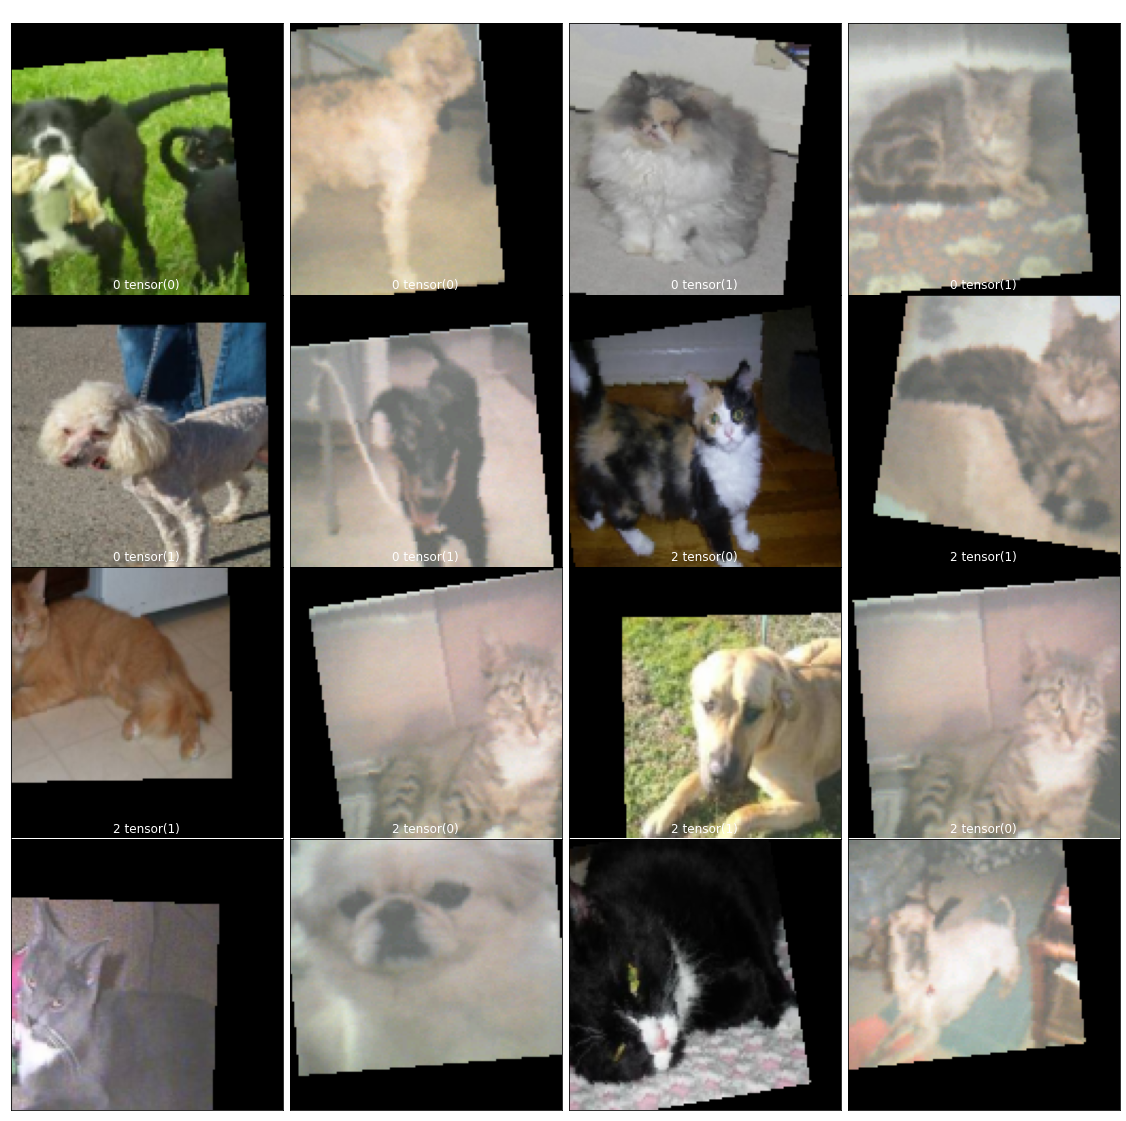

In [5]:
train_loader_c.dataset.visualize_batch()

In [6]:
conf_c.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
conf_d.device = conf_c.device
print('Running on device: {}'.format(conf_c.device))

Running on device: cuda:0


In [7]:
# set simulation configuration
ai8x.set_device(device=85, simulate=False, round_avg=False)

# create the classifier model
load_model_path = "jupyter_logging/high_acc_b32_long_train___2022.06.24-175831/catdognet_qat_best.pth.tar"
enc_model = mod.CatsAndDogsClassifier()                       
checkpoint = torch.load(load_model_path, map_location=lambda storage, loc: storage)
ai8x.fuse_bn_layers(enc_model)
enc_model = apputils.load_lean_checkpoint(enc_model, load_model_path, model_device=conf_c.device)
ai8x.update_model(enc_model)
enc_model = enc_model.to(conf_c.device)

# create the DCD model
load_model_path = "jupyter_logging/dcd_train___2022.07.05-141916/catdogdcdnet_best.pth.tar"
dcd_model = mod.CatsAndDogsDCD()                       
checkpoint = torch.load(load_model_path, map_location=lambda storage, loc: storage)
ai8x.fuse_bn_layers(dcd_model)
dcd_model = apputils.load_lean_checkpoint(dcd_model, load_model_path, model_device=conf_c.device)
ai8x.update_model(dcd_model)
dcd_model = dcd_model.to(conf_c.device)

# configure tensorboard
dummy_input1 = torch.randn((1, ) + conf_c.dimensions)
tflogger.tblogger.writer.add_graph(enc_model.to('cpu'), (dummy_input1,), False)

all_loggers.append(tflogger)
all_tbloggers = [tflogger]

=> loading checkpoint jupyter_logging/high_acc_b32_long_train___2022.06.24-175831/catdognet_qat_best.pth.tar
=> Checkpoint contents:
+----------------------+-------------+-----------+
| Key                  | Type        | Value     |
|----------------------+-------------+-----------|
| arch                 | str         | catdognet |
| compression_sched    | dict        |           |
| epoch                | int         | 1425      |
| extras               | dict        |           |
| optimizer_state_dict | dict        |           |
| optimizer_type       | type        | Adam      |
| state_dict           | OrderedDict |           |
+----------------------+-------------+-----------+

=> Checkpoint['extras'] contents:
+--------------+--------+---------+
| Key          | Type   |   Value |
|--------------+--------+---------|
| best_epoch   | int    | 1425    |
| best_top1    | float  |   94.95 |
| current_top1 | float  |   94.95 |
+--------------+--------+---------+

Loaded compression

Configuring device: MAX78000, simulate=False.


=> loaded 'state_dict' from checkpoint 'jupyter_logging/high_acc_b32_long_train___2022.06.24-175831/catdognet_qat_best.pth.tar'
=> loading checkpoint jupyter_logging/dcd_train___2022.07.05-141916/catdogdcdnet_best.pth.tar
=> Checkpoint contents:
+----------------------+-------------+--------------+
| Key                  | Type        | Value        |
|----------------------+-------------+--------------|
| arch                 | str         | catdogdcdnet |
| compression_sched    | dict        |              |
| epoch                | int         | 31           |
| extras               | dict        |              |
| optimizer_state_dict | dict        |              |
| optimizer_type       | type        | Adam         |
| state_dict           | OrderedDict |              |
+----------------------+-------------+--------------+

=> Checkpoint['extras'] contents:
+--------------+--------+---------+
| Key          | Type   |   Value |
|--------------+--------+---------|
| best_epoch   | 

In [13]:
# optimizer
conf_c.optimizer = optim.Adam(enc_model.parameters(), lr=conf_c.lr)
msglogger.info('Optimizer Type: %s', type(conf_c.optimizer))

conf_d.optimizer = optim.Adam(dcd_model.parameters(), lr=conf_c.lr)
msglogger.info('Optimizer Type: %s', type(conf_d.optimizer))

# lr schedule
conf_c.lr_scheduler = optim.lr_scheduler.MultiStepLR(conf_c.optimizer, milestones=[8, 20,100], gamma=0.5)
conf_d.lr_scheduler = optim.lr_scheduler.MultiStepLR(conf_d.optimizer, milestones=[8, 20,100], gamma=0.5)
msglogger.info("lr_schedule:%s","base: "+str(conf_c.lr_scheduler.base_lrs)+" milestones: "+str(conf_c.lr_scheduler.milestones)+ " gamma: "+str(conf_c.lr_scheduler.gamma))

# loss function
conf_c.criterion = torch.nn.CrossEntropyLoss().to(conf_c.device)
conf_d.criterion = torch.nn.CrossEntropyLoss().to(conf_d.device)
compression_scheduler_c = distiller.CompressionScheduler(enc_model)
compression_scheduler_d = distiller.CompressionScheduler(dcd_model)

Optimizer Type: <class 'torch.optim.adam.Adam'>
Optimizer Type: <class 'torch.optim.adam.Adam'>
lr_schedule:base: [0.00025] milestones: Counter({8: 1, 20: 1, 100: 1}) gamma: 0.5


In [14]:
# register a forward hook to get the encoder output
conf_c.enc_output = {}
def get_embedding(name):
    def hook(model, input, output):
        conf_c.enc_output[name] = output.detach()
    return hook

# get the activations
enc_model.fc1.register_forward_hook(get_embedding('fc1'))
enc_model = enc_model.to(conf_c.device)
conf_c.enc_model = enc_model

conf_d.dcd_model = dcd_model

def cd_DCD_forward(model, batch, conf, conf_c):
    inputs1, inputs2, target, img1_label, imgs2_label = batch[0].to(conf.device), batch[1].to(conf.device), batch[2].to(conf.device), batch[3].to(conf.device), batch[4].to(conf.device)

    # encoder output for sample 1
    out1 = conf_c.enc_model(inputs1)
    enc1 = conf_c.enc_output['fc1']

    # encoder output for sample 2
    out2 = conf_c.enc_model(inputs2)
    enc2 = conf_c.enc_output['fc1']

    # concatenate and pass through DCD
    X_cat = torch.cat([enc1,enc2],1)
    return model(X_cat.detach()), target

def cd_classifier_forward(model, batch, conf, conf_d):
    inputs1, inputs2, target, imgs1_labels, imgs2_labels = batch[0].to(conf.device), batch[1].to(conf.device), batch[2].to(conf.device), batch[3].to(conf.device), batch[4].to(conf.device)

    # encoder output for sample 1
    out1 = conf.enc_model(inputs1)
    enc1 = conf.enc_output['fc1']

    # encoder output for sample 2
    out2 = conf.enc_model(inputs2)
    enc2 = conf.enc_output['fc1']

    # concatenate and pass through DCD
    X_cat = torch.cat([enc1,enc2],1)

    # the dcd output and target as well as the classifier outputs and targets
    return conf_d.dcd_model(X_cat.detach()), target, model(inputs1), imgs1_labels, model(inputs2), imgs2_labels

def cd_classifier_forward2(model, batch, conf):
    # get the batch items and send to GPU
    inputs, target = batch[0].to(conf.device), batch[1].to(conf.device)

    # get the output
    return model(inputs), target

conf_d.forward = cd_DCD_forward
conf_c.forward = cd_classifier_forward
conf_cd.forward = cd_classifier_forward2
conf_cd.device = conf_d.device
conf_cd.criterion = conf_c.criterion
conf_cd.num_classes = conf_c.num_classes


In [15]:
batch = next(iter(val_loader_d))
out, target = conf_d.forward(dcd_model,batch,conf_d,conf_c)
print(torch.argmax(out,axis=1)-target)

tensor([ 0,  0,  0,  0,  0,  1,  0, -1,  0,  0, -2,  0,  0,  0,  0,  0],
       device='cuda:0')


In [16]:
def adv_validate(val_loader_c, val_loader_d, classifier_model, conf_c, discriminator_model, conf_d, loggers, epoch=-1, tflogger=-1):
    
    # store loss stats
    enc_losses = {'class_loss': tnt.AverageValueMeter(),'disc_c_loss': tnt.AverageValueMeter()}
    disc_losses = {'disc_d_loss': tnt.AverageValueMeter()}

    classerr_class = tnt.ClassErrorMeter(accuracy=True, topk=(1, min(conf_c.num_classes, 5))) # classification error
    classerr_disc_c = tnt.ClassErrorMeter(accuracy=True, topk=(1, min(conf_d.num_classes, 5))) # discriminator error classification phase
    classerr_disc_d = tnt.ClassErrorMeter(accuracy=True, topk=(1, min(conf_d.num_classes, 5))) # discriminator error during dcd phase

    # validation set info
    total_samples = len(val_loader_c.sampler)
    batch_size = val_loader_c.batch_size

    confusion_class = tnt.ConfusionMeter(conf_c.num_classes)
    confusion_disc_c = tnt.ConfusionMeter(conf_d.num_classes)
    confusion_disc_d = tnt.ConfusionMeter(conf_d.num_classes)

    total_steps = (total_samples + conf_c.batch_size - 1) // conf_c.batch_size
    msglogger.info('%d samples (%d per mini-batch)', total_samples, conf_c.batch_size)

    # Switch to evaluation mode
    classifier_model.eval()
    discriminator_model.eval()

    class_probs = []
    class_preds = []
    dcd_c_probs = []
    dcd_c_preds = []
    dcd_d_probs = []
    dcd_d_preds = []

    # iterate over the batches in the validation set
    for validation_step in range(32):
        with torch.no_grad():
            
            batch_c = next(iter(val_loader_c)) # get a single batch
            batch_d = next(iter(val_loader_d))

            # pass the input through the classifier
            dcd_out_c, dcd_target_c, img1_out, img1_target, img2_out, img2_target = conf_c.forward(classifier_model, batch_c, conf_c, conf_d)

            # pass the input through the dcd
            dcd_out_d, dcd_target_d = conf_d.forward(discriminator_model, batch_d, conf_d, conf_c)
            # print(conf_c.device)
            # print(conf_d.device)
            # print("model on gpu:", next(classifier_model.parameters()).is_cuda)
            # print("model on gpu:", next(discriminator_model.parameters()).is_cuda)

            # correct output for accurate loss calculation
            if conf_c.args.act_mode_8bit:
                dcd_out_c /= 128.
                dcd_out_d /= 128.
                img1_out /= 128.
                img2_out /= 128.
                for key in model.__dict__['_modules'].keys():
                    if (hasattr(model.__dict__['_modules'][key], 'wide')
                            and model.__dict__['_modules'][key].wide):
                        dcd_out_c /= 256.
                        dcd_out_d /= 256.
                        img1_out /= 256.
                        img2_out /= 256.
            
            # collect all the losses
            dcd_loss = conf_c.criterion(dcd_out_c, dcd_target_c)
            img1_loss = conf_c.criterion(img1_out, img1_target)
            img2_loss = conf_c.criterion(img2_out, img2_target)
            loss = 0.2*dcd_loss + img1_loss + img2_loss
            enc_losses['class_loss'].add(img1_loss.item() + img2_loss.item())
            enc_losses['disc_c_loss'].add(dcd_loss.item())

            # collect accuracy stats
            classerr_class.add(img1_out.data, img1_target)
            classerr_class.add(img2_out.data, img2_target)
            classerr_disc_c.add(dcd_out_c.data, dcd_target_c)

            confusion_class.add(img1_out.data, img1_target)
            confusion_class.add(img2_out.data, img2_target)
            confusion_disc_c.add(dcd_out_c.data, dcd_target_c)


            dcd_loss_d = conf_d.criterion(dcd_out_d, dcd_target_d)
            disc_losses['disc_d_loss'].add(dcd_loss_d.item())

            classerr_disc_d.add(dcd_out_d.data, dcd_target_d)
            confusion_disc_d.add(dcd_out_d.data, dcd_target_d)
            

            # store prediction stats
            steps_completed = (validation_step+1)
            if steps_completed % conf_c.print_freq == 0 or steps_completed == total_steps:
                class_probs_batch = [torch.nn.functional.softmax(el, dim=0) for el in torch.cat((img1_out,img2_out))]
                dcd_c_probs_batch = [torch.nn.functional.softmax(el, dim=0) for el in dcd_out_c]
                dcd_d_probs_batch = [torch.nn.functional.softmax(el, dim=0) for el in dcd_out_d]

                _, class_preds_batch = torch.max(torch.cat((img1_out,img2_out)), 1)
                _, dcd_c_preds_batch = torch.max(dcd_out_c, 1)
                _, dcd_d_preds_batch = torch.max(dcd_out_d, 1)

                class_probs.append(class_probs_batch)
                class_preds.append(class_preds_batch)
                dcd_c_probs.append(dcd_c_probs_batch)
                dcd_c_preds.append(dcd_c_preds_batch)
                dcd_d_probs.append(dcd_d_probs_batch)
                dcd_d_preds.append(dcd_d_preds_batch)

                stats = (
                    '',
                    OrderedDict([('Class Loss', enc_losses['class_loss'].mean),
                                 ('disc_c Loss', enc_losses['disc_c_loss'].mean),
                                 ('disc_d Loss', disc_losses['disc_d_loss'].mean),
                                    ('Class Top1', classerr_class.value(1)),
                                    ('disc_c Top1', classerr_disc_c.value(1)),
                                    ('disc_d Top1', classerr_disc_d.value(1))]),
                                    
                )
                if conf_c.num_classes > 5:
                    stats[1]['Top5'] = classerr_class.value(5)

                distiller.log_training_progress(stats, None, epoch, steps_completed,
                                                total_steps, conf_c.print_freq, loggers)


    if conf_c.num_classes > 5:
        msglogger.info('==> Class Top1: %.3f    Class Top5: %.3f    Class Loss: %.3f    DCD_c Top1: %.3f DCD_c Loss: %.3f    DCD_d Top1: %.3f DCD_d Loss: %.3f\n',
                        classerr_class.value()[0], classerr_class.value()[1],
                        enc_losses['class_loss'].mean, classerr_disc_c.value()[0], enc_losses['disc_c_loss'].mean,
                        classerr_disc_d.value()[0], disc_losses['disc_d_loss'].mean)
    else:
        msglogger.info('==> Class Top1: %.3f    Class Loss: %.3f    DCD_c Top1: %.3f DCD_c Loss: %.3f    DCD_d Top1: %.3f DCD_d Loss: %.3f\n',
                        classerr_class.value()[0],
                        enc_losses['class_loss'].mean, classerr_disc_c.value()[0], enc_losses['disc_c_loss'].mean,
                        classerr_disc_d.value()[0], disc_losses['disc_d_loss'].mean)

    msglogger.info('==> Confusion Class:\n%s\n', str(confusion_class.value()))
    msglogger.info('==> Confusion DCD_c:\n%s\n', str(confusion_disc_c.value()))
    msglogger.info('==> Confusion DCD_d:\n%s\n', str(confusion_disc_d.value()))

    if tflogger is not None:
        cf = nnplot.confusion_matrix(confusion_class.value(), conf_c.labels)
        tflogger.tblogger.writer.add_image('Validation/ConfusionMatrix_class', cf, epoch,
                                            dataformats='HWC')
        cf = nnplot.confusion_matrix(confusion_disc_c.value(), conf_d.labels)
        tflogger.tblogger.writer.add_image('Validation/ConfusionMatrix_disc_c', cf, epoch,
                                            dataformats='HWC')

        cf = nnplot.confusion_matrix(confusion_disc_d.value(), conf_d.labels)
        tflogger.tblogger.writer.add_image('Validation/ConfusionMatrix_disc_d', cf, epoch,
                                            dataformats='HWC')
    
    return classerr_class.value(1), classerr_class.value(min(conf_c.num_classes, 5)), enc_losses['class_loss'].mean, classerr_disc_c.value(1), enc_losses['disc_c_loss'].mean, classerr_disc_d.value(1), disc_losses['disc_d_loss'].mean

In [17]:
def adv_train(train_loader_c, train_loader_d, val_loader_c, val_loader_d, classifier_model, conf_c, discriminator_model, conf_d, conf_cd):

    # store model history across epochs
    perf_scores_history = []

    classifier_model = classifier_model.to(conf_c.device)
    discriminator_model = discriminator_model.to(conf_d.device)

    # start the clock
    tic = datetime.now()

    batches_per_phase = 1

    # =============================== training loop =====================================
    for epoch in range(0, conf_c.num_epochs):
        # check if need to switch to QAT
        if epoch > 0 and epoch == conf_c.qat_policy['start_epoch']:
            print('QAT is starting!')
            # Fuse the BN parameters into conv layers before Quantization Aware Training (QAT)
            ai8x.fuse_bn_layers(classifier_model)
            ai8x.fuse_bn_layers(discriminator_model)

            # Switch model from unquantized to quantized for QAT
            ai8x.initiate_qat(classifier_model, conf_c.qat_policy)
            ai8x.initiate_qat(discriminator_model, conf_d.qat_policy)

            # Model is re-transferred to GPU in case parameters were added
            classifier_model.to(conf_c.device)
            discriminator_model.to(conf_d.device)

            # Empty the performance scores list for QAT operation
            perf_scores_history = []
            conf_c.model_name = f'{conf_c.model_name}_qat'
            conf_d.model_name = f'{conf_d.model_name}_qat'

        # store loss and training stats
        enc_losses = {'class_loss': tnt.AverageValueMeter(),'disc_c_loss': tnt.AverageValueMeter()}
        disc_losses = {'disc_d_loss': tnt.AverageValueMeter()}

        classerr_class = tnt.ClassErrorMeter(accuracy=True, topk=(1, min(conf_c.num_classes, 5))) # classification error
        classerr_disc_c = tnt.ClassErrorMeter(accuracy=True, topk=(1, min(conf_d.num_classes, 5))) # discriminator error classification phase
        classerr_disc_d = tnt.ClassErrorMeter(accuracy=True, topk=(1, min(conf_d.num_classes, 5))) # discriminator error during dcd phase

        # logging stats
        total_samples = len(train_loader_c.sampler)
        steps_per_epoch = (total_samples + conf_c.batch_size - 1) // conf_c.batch_size
        msglogger.info('Training epoch: %d samples (%d per mini-batch)', total_samples, conf_c.batch_size)

        # Switch to train mode
        classifier_model.train()
        discriminator_model.train()
        acc_stats = []

        # =================================== batch loop ===================================
        encoder_on = False
        switch_d = False
        switch_c = False

        print("steps in an epoch:", len(train_loader_c))

        #for train_step, batch in enumerate(train_loader_c):
        for train_step in range(64): # reduce epocj to 64 batches since we are randomly sampling
            # switch phase every four batches
            if (train_step % batches_per_phase) == 0:
                if encoder_on == True: # switch to train dcd
                    switch_d = True
                if encoder_on == False: # switch to train encoder
                    switch_c = True
                encoder_on = not encoder_on

            # train the encoder to trick the discriminator
            if encoder_on:
                if switch_c == True: # create new error collectors at the start of the phase
                    switch_c = False
                    confusion_class = tnt.ConfusionMeter(conf_c.num_classes)
                    confusion_disc_c = tnt.ConfusionMeter(conf_d.num_classes)

                batch = next(iter(train_loader_c)) # get a single batch

                # pass the input through the classifier
                dcd_out, dcd_target, img1_out, img1_target, img2_out, img2_target = conf_c.forward(classifier_model, batch, conf_c, conf_d) 
                
                # collect all the losses
                dcd_loss = conf_c.criterion(dcd_out, dcd_target)
                img1_loss = conf_c.criterion(img1_out, img1_target)
                img2_loss = conf_c.criterion(img2_out, img2_target)
                loss = 0.2*dcd_loss + img1_loss + img2_loss

                # collect accuracy stats
                classerr_class.add(img1_out.data, img1_target)
                classerr_class.add(img2_out.data, img2_target)
                classerr_disc_c.add(dcd_out.data, dcd_target)

                confusion_class.add(img1_out.data, img1_target)
                confusion_class.add(img2_out.data, img2_target)
                confusion_disc_c.add(dcd_out.data, dcd_target)
                
                # add the losses
                enc_losses['class_loss'].add(img1_loss.item() + img2_loss.item())
                enc_losses['disc_c_loss'].add(dcd_loss.item())

                # reset the optimizer
                conf_c.optimizer.zero_grad()

                # backwards pass and parameter update
                loss.backward()
                conf_c.optimizer.step()

                # track batch stats
                steps_completed = (train_step+1)

                # log stats
                if (steps_completed+batches_per_phase) % conf_c.print_freq == 0 or steps_completed == steps_per_epoch:
                    # Log some statistics
                    errs = OrderedDict()
                    if classerr_class.n != 0:
                        errs['class Top1'] = classerr_class.value(1)
                        errs['disc_c Top1'] = classerr_disc_c.value(1)
                        if conf_c.num_classes > 5:
                            errs['class Top5'] = classerr_class.value(5)
                    else:
                        errs['class Top1'] = None
                        errs['class Top5'] = None
                        errs['disc_c Top1'] = None

                    stats_dict = OrderedDict()
                    for loss_name, meter in enc_losses.items():
                        stats_dict[loss_name] = meter.mean
                    stats_dict.update(errs)
                    
                    stats_dict['LR'] = conf_c.optimizer.param_groups[0]['lr']
                    stats = ('Adv/Training_c/', stats_dict)
                    params = None
                    distiller.log_training_progress(stats,params,epoch,steps_completed,steps_per_epoch,conf_c.print_freq,all_loggers)

            # train the discriminator
            else:
                if switch_d == True:
                    switch_d = False
                    confusion_disc_d = tnt.ConfusionMeter(conf_d.num_classes)

                batch = next(iter(train_loader_d))

                # pass the input through the dcd
                dcd_out, dcd_target = conf_d.forward(discriminator_model, batch, conf_d, conf_c) 
                
                dcd_loss_d = conf_d.criterion(dcd_out, dcd_target)

                classerr_disc_d.add(dcd_out.data, dcd_target)
                confusion_disc_d.add(dcd_out.data, dcd_target)
                
                disc_losses['disc_d_loss'].add(dcd_loss_d.item())

                # reset the optimizer
                conf_d.optimizer.zero_grad()

                # backwards pass and parameter update
                dcd_loss_d.backward()
                conf_d.optimizer.step()

                # track batch stats
                steps_completed = (train_step+1)

                # log stats every 10 batches
                if steps_completed % conf_d.print_freq == 0 or steps_completed == steps_per_epoch:
                    # Log some statistics
                    errs = OrderedDict()
                    if classerr_disc_d.n != 0:
                        errs['disc_d Top1'] = classerr_disc_d.value(1)
                    else:
                        errs['disc_d Top1'] = None

                    stats_dict = OrderedDict()
                    for loss_name, meter in disc_losses.items():
                        stats_dict[loss_name] = meter.mean
                    stats_dict.update(errs)
                    
                    stats_dict['LR'] = conf_d.optimizer.param_groups[0]['lr']
                    stats = ('Adv/Training_d/', stats_dict)
                    params = None
                    distiller.log_training_progress(stats,params,epoch,steps_completed,steps_per_epoch,conf_d.print_freq,all_loggers)


        # ============================= validation =======================
        msglogger.info('--- validate (epoch=%d)-----------', epoch)
        class_top1, class_top5, class_loss, disc_c_top1, disc_c_loss, disc_d_top1, disc_d_loss = adv_validate(val_loader_c, val_loader_d, classifier_model,\
                                                                                                          conf_c, discriminator_model, conf_d, [pylogger], epoch, tflogger)

        # store validation stats
        stats = (
                    'Adv/Validation/',
                    OrderedDict([('Class Loss', class_loss),
                                 ('disc_c Loss', disc_c_loss),
                                 ('disc_d Loss', disc_d_loss),
                                    ('Class Top1', class_top1),
                                    ('disc_c Top1', disc_c_top1),
                                    ('disc_d Top1', disc_d_top1)]),
                                    
                )
        
        if conf_c.num_classes > 5:
            stats[1]['Top5'] = classerr_class.value(5)

        distiller.log_training_progress(stats, None, epoch, steps_completed=0, total_steps=1,
                                                log_freq=1, loggers=all_tbloggers)

        perf_scores_history.append(distiller.MutableNamedTuple({'disc_top1_diff': disc_c_top1-disc_d_top1, 'epoch': epoch}))
        # Keep perf_scores_history sorted from best to worst
        # Sort by top1 as main sort key, then sort by top5 and epoch
        perf_scores_history.sort(key=operator.attrgetter('disc_top1_diff','epoch'),reverse=True)
        for score in perf_scores_history[:1]:
            msglogger.info('==> Best [disc_top1_diff: %.3f on epoch: %d]',
                            score.disc_top1_diff, score.epoch)

        # Save the checkpoint
        is_best = epoch == perf_scores_history[0].epoch
        checkpoint_extras = {'current_top1': disc_c_top1-disc_d_top1,
                            'best_top1': perf_scores_history[0].disc_top1_diff,
                            'best_epoch': perf_scores_history[0].epoch}

        apputils.save_checkpoint(epoch, conf_c.model_name, classifier_model, optimizer=conf_c.optimizer,
                                    scheduler=compression_scheduler_c, extras=checkpoint_extras,
                                    is_best=is_best, name=conf_c.model_name,
                                    dir=msglogger.logdir)

        conf_c.lr_scheduler.step()
        conf_d.lr_scheduler.step()

    # ========================= test ============================
    # top1, top5, losses = validate(val_loader, model, [pylogger], conf, epoch, tflogger)
    # msglogger.info('==> Test Set [Top1: %.3f   Top5: %.3f  on test set]', top1, top5)
    msglogger.info('Training time: %s', datetime.now() - tic)

In [18]:
adv_train(train_loader_c, train_loader_d, val_loader_c, val_loader_d, enc_model, conf_c, dcd_model, conf_d, conf_cd)

Training epoch: 8000 samples (32 per mini-batch)


steps in an epoch: 250


Epoch: [0][   31/  250]    class_loss 0.198333    disc_c_loss 0.612600    class Top1 95.605469    disc_c Top1 83.203125    LR 0.000250    
Epoch: [0][   32/  250]    disc_d_loss 4.735384    disc_d Top1 49.218750    LR 0.000250    
Epoch: [0][   63/  250]    class_loss 0.107867    disc_c_loss 0.478589    class Top1 97.802734    disc_c Top1 87.207031    LR 0.000250    
Epoch: [0][   64/  250]    disc_d_loss 4.804081    disc_d Top1 48.242188    LR 0.000250    
--- validate (epoch=0)-----------
8000 samples (32 per mini-batch)
Epoch: [0][   32/  250]    Class Loss 0.004255    disc_c Loss 0.254766    disc_d Loss 4.527141    Class Top1 100.000000    disc_c Top1 92.480469    disc_d Top1 52.929688    
==> Class Top1: 100.000    Class Loss: 0.004    DCD_c Top1: 92.480 DCD_c Loss: 0.255    DCD_d Top1: 52.930 DCD_d Loss: 4.527

==> Confusion Class:
[[1112    0]
 [   0  936]]

==> Confusion DCD_c:
[[498  36   0   0]
 [  0   0   0   0]
 [  0  11 449  30]
 [  0   0   0   0]]

==> Confusion DCD_d:
[[

steps in an epoch: 250


Epoch: [1][   31/  250]    class_loss 0.005154    disc_c_loss 0.285100    class Top1 100.000000    disc_c Top1 89.062500    LR 0.000250    
Epoch: [1][   32/  250]    disc_d_loss 4.559571    disc_d Top1 46.875000    LR 0.000250    
Traceback (most recent call last):
  File "/home/geffencooper/.pyenv/versions/3.8.11/lib/python3.8/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/home/geffencooper/.pyenv/versions/3.8.11/lib/python3.8/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/home/geffencooper/.pyenv/versions/3.8.11/lib/python3.8/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/home/geffencooper/.pyenv/versions/3.8.11/lib/python3.8/shutil.py", line 722, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/home/geffencooper/.pyenv/versions/3.8.11/lib/python3.8/shutil.py", line 720, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not emp

steps in an epoch: 250


Epoch: [2][   31/  250]    class_loss 0.002357    disc_c_loss 0.413170    class Top1 100.000000    disc_c Top1 77.734375    LR 0.000250    
Epoch: [2][   32/  250]    disc_d_loss 3.204073    disc_d Top1 52.734375    LR 0.000250    
Epoch: [2][   63/  250]    class_loss 0.002139    disc_c_loss 0.393401    class Top1 100.000000    disc_c Top1 78.906250    LR 0.000250    
Epoch: [2][   64/  250]    disc_d_loss 3.249441    disc_d Top1 51.171875    LR 0.000250    
--- validate (epoch=2)-----------
8000 samples (32 per mini-batch)
Epoch: [2][   32/  250]    Class Loss 0.000706    disc_c Loss 0.380464    disc_d Loss 2.856511    Class Top1 100.000000    disc_c Top1 87.792969    disc_d Top1 57.812500    
==> Class Top1: 100.000    Class Loss: 0.001    DCD_c Top1: 87.793 DCD_c Loss: 0.380    DCD_d Top1: 57.812 DCD_d Loss: 2.857

==> Confusion Class:
[[1056    0]
 [   0  992]]

==> Confusion DCD_c:
[[421  95   0   0]
 [  0   0   0   0]
 [  0   0 478  30]
 [  0   0   0   0]]

==> Confusion DCD_d:


steps in an epoch: 250


Epoch: [3][   31/  250]    class_loss 0.001642    disc_c_loss 0.343749    class Top1 100.000000    disc_c Top1 86.523438    LR 0.000250    
Epoch: [3][   32/  250]    disc_d_loss 3.070660    disc_d Top1 56.250000    LR 0.000250    
Epoch: [3][   63/  250]    class_loss 0.001673    disc_c_loss 0.346504    class Top1 100.000000    disc_c Top1 88.574219    LR 0.000250    
Epoch: [3][   64/  250]    disc_d_loss 2.763118    disc_d Top1 59.375000    LR 0.000250    
--- validate (epoch=3)-----------
8000 samples (32 per mini-batch)
Epoch: [3][   32/  250]    Class Loss 0.000556    disc_c Loss 0.315763    disc_d Loss 2.248182    Class Top1 100.000000    disc_c Top1 91.894531    disc_d Top1 66.015625    
==> Class Top1: 100.000    Class Loss: 0.001    DCD_c Top1: 91.895 DCD_c Loss: 0.316    DCD_d Top1: 66.016 DCD_d Loss: 2.248

==> Confusion Class:
[[1105    0]
 [   0  943]]

==> Confusion DCD_c:
[[476  51   0   0]
 [  0   0   0   0]
 [  0   0 465  32]
 [  0   0   0   0]]

==> Confusion DCD_d:


steps in an epoch: 250


Epoch: [4][   31/  250]    class_loss 0.001576    disc_c_loss 0.323899    class Top1 100.000000    disc_c Top1 89.843750    LR 0.000250    
Epoch: [4][   32/  250]    disc_d_loss 2.621656    disc_d Top1 58.984375    LR 0.000250    
Epoch: [4][   63/  250]    class_loss 0.001536    disc_c_loss 0.319888    class Top1 100.000000    disc_c Top1 86.816406    LR 0.000250    
Epoch: [4][   64/  250]    disc_d_loss 2.382943    disc_d Top1 58.203125    LR 0.000250    
--- validate (epoch=4)-----------
8000 samples (32 per mini-batch)
Epoch: [4][   32/  250]    Class Loss 0.000476    disc_c Loss 0.300244    disc_d Loss 2.219989    Class Top1 100.000000    disc_c Top1 84.863281    disc_d Top1 59.375000    
==> Class Top1: 100.000    Class Loss: 0.000    DCD_c Top1: 84.863 DCD_c Loss: 0.300    DCD_d Top1: 59.375 DCD_d Loss: 2.220

==> Confusion Class:
[[1098    0]
 [   0  950]]

==> Confusion DCD_c:
[[362 142   0   0]
 [  0   0   0   0]
 [  0   0 507  13]
 [  0   0   0   0]]

==> Confusion DCD_d:


steps in an epoch: 250


Epoch: [5][   31/  250]    class_loss 0.001231    disc_c_loss 0.304157    class Top1 100.000000    disc_c Top1 86.523438    LR 0.000250    
Epoch: [5][   32/  250]    disc_d_loss 2.288256    disc_d Top1 58.203125    LR 0.000250    
Epoch: [5][   63/  250]    class_loss 0.001296    disc_c_loss 0.319229    class Top1 100.000000    disc_c Top1 86.230469    LR 0.000250    
Epoch: [5][   64/  250]    disc_d_loss 2.074367    disc_d Top1 55.664062    LR 0.000250    
--- validate (epoch=5)-----------
8000 samples (32 per mini-batch)
Epoch: [5][   32/  250]    Class Loss 0.000405    disc_c Loss 0.304633    disc_d Loss 1.668587    Class Top1 100.000000    disc_c Top1 89.160156    disc_d Top1 60.156250    
==> Class Top1: 100.000    Class Loss: 0.000    DCD_c Top1: 89.160 DCD_c Loss: 0.305    DCD_d Top1: 60.156 DCD_d Loss: 1.669

==> Confusion Class:
[[1084    0]
 [   0  964]]

==> Confusion DCD_c:
[[405 111   0   0]
 [  0   0   0   0]
 [  0   0 508   0]
 [  0   0   0   0]]

==> Confusion DCD_d:


steps in an epoch: 250


Epoch: [6][   31/  250]    class_loss 0.001405    disc_c_loss 0.344801    class Top1 100.000000    disc_c Top1 85.937500    LR 0.000250    
Epoch: [6][   32/  250]    disc_d_loss 1.642352    disc_d Top1 58.984375    LR 0.000250    
Epoch: [6][   63/  250]    class_loss 0.001372    disc_c_loss 0.374529    class Top1 100.000000    disc_c Top1 88.378906    LR 0.000250    
Epoch: [6][   64/  250]    disc_d_loss 1.733355    disc_d Top1 56.640625    LR 0.000250    
--- validate (epoch=6)-----------
8000 samples (32 per mini-batch)
Epoch: [6][   32/  250]    Class Loss 0.000375    disc_c Loss 0.436298    disc_d Loss 1.443531    Class Top1 100.000000    disc_c Top1 89.550781    disc_d Top1 60.546875    
==> Class Top1: 100.000    Class Loss: 0.000    DCD_c Top1: 89.551 DCD_c Loss: 0.436    DCD_d Top1: 60.547 DCD_d Loss: 1.444

==> Confusion Class:
[[1102    0]
 [   0  946]]

==> Confusion DCD_c:
[[438  58   0   0]
 [  0   0   0   0]
 [  0   0 479  49]
 [  0   0   0   0]]

==> Confusion DCD_d:


steps in an epoch: 250


Epoch: [7][   31/  250]    class_loss 0.001239    disc_c_loss 0.465847    class Top1 100.000000    disc_c Top1 87.890625    LR 0.000250    
Epoch: [7][   32/  250]    disc_d_loss 1.711391    disc_d Top1 53.906250    LR 0.000250    
Epoch: [7][   63/  250]    class_loss 0.001237    disc_c_loss 0.480803    class Top1 100.000000    disc_c Top1 81.835938    LR 0.000250    
Epoch: [7][   64/  250]    disc_d_loss 1.547610    disc_d Top1 55.273438    LR 0.000250    
--- validate (epoch=7)-----------
8000 samples (32 per mini-batch)
Epoch: [7][   32/  250]    Class Loss 0.000352    disc_c Loss 0.536458    disc_d Loss 1.333106    Class Top1 100.000000    disc_c Top1 67.285156    disc_d Top1 57.226562    
==> Class Top1: 100.000    Class Loss: 0.000    DCD_c Top1: 67.285 DCD_c Loss: 0.536    DCD_d Top1: 57.227 DCD_d Loss: 1.333

==> Confusion Class:
[[1103    0]
 [   0  945]]

==> Confusion DCD_c:
[[426  75   0   0]
 [  0   0   0   0]
 [  0   0 263 260]
 [  0   0   0   0]]

==> Confusion DCD_d:


QAT is starting!
steps in an epoch: 250


Epoch: [8][   31/  250]    class_loss 0.001113    disc_c_loss 1.030583    class Top1 100.000000    disc_c Top1 60.937500    LR 0.000125    
Epoch: [8][   32/  250]    disc_d_loss 1.117327    disc_d Top1 57.031250    LR 0.000125    
Epoch: [8][   63/  250]    class_loss 0.001081    disc_c_loss 1.029001    class Top1 100.000000    disc_c Top1 61.816406    LR 0.000125    
Epoch: [8][   64/  250]    disc_d_loss 1.119016    disc_d Top1 56.835938    LR 0.000125    
--- validate (epoch=8)-----------
8000 samples (32 per mini-batch)
Epoch: [8][   32/  250]    Class Loss 0.000329    disc_c Loss 1.028378    disc_d Loss 1.098605    Class Top1 100.000000    disc_c Top1 58.300781    disc_d Top1 58.007812    
==> Class Top1: 100.000    Class Loss: 0.000    DCD_c Top1: 58.301 DCD_c Loss: 1.028    DCD_d Top1: 58.008 DCD_d Loss: 1.099

==> Confusion Class:
[[1039    0]
 [   0 1009]]

==> Confusion DCD_c:
[[429  56   0   0]
 [  0   0   0   0]
 [  0   0 292 247]
 [  0   0   0   0]]

==> Confusion DCD_d:


steps in an epoch: 250


Epoch: [9][   31/  250]    class_loss 0.001195    disc_c_loss 1.025492    class Top1 100.000000    disc_c Top1 65.820312    LR 0.000125    
Epoch: [9][   32/  250]    disc_d_loss 1.135936    disc_d Top1 51.953125    LR 0.000125    
Epoch: [9][   63/  250]    class_loss 0.001129    disc_c_loss 1.023742    class Top1 100.000000    disc_c Top1 63.281250    LR 0.000125    
Epoch: [9][   64/  250]    disc_d_loss 1.117770    disc_d Top1 51.562500    LR 0.000125    
--- validate (epoch=9)-----------
8000 samples (32 per mini-batch)
Epoch: [9][   32/  250]    Class Loss 0.000320    disc_c Loss 1.021137    disc_d Loss 1.106339    Class Top1 100.000000    disc_c Top1 61.230469    disc_d Top1 56.445312    
==> Class Top1: 100.000    Class Loss: 0.000    DCD_c Top1: 61.230 DCD_c Loss: 1.021    DCD_d Top1: 56.445 DCD_d Loss: 1.106

==> Confusion Class:
[[1068    0]
 [   0  980]]

==> Confusion DCD_c:
[[504  40   0   0]
 [  0   0   0   0]
 [  0   0 254 226]
 [  0   0   0   0]]

==> Confusion DCD_d:


steps in an epoch: 250


Epoch: [10][   31/  250]    class_loss 0.001283    disc_c_loss 1.019132    class Top1 100.000000    disc_c Top1 64.453125    LR 0.000125    
Epoch: [10][   32/  250]    disc_d_loss 1.096244    disc_d Top1 55.468750    LR 0.000125    
Epoch: [10][   63/  250]    class_loss 0.001147    disc_c_loss 1.017987    class Top1 100.000000    disc_c Top1 63.085938    LR 0.000125    
Epoch: [10][   64/  250]    disc_d_loss 1.115328    disc_d Top1 52.343750    LR 0.000125    
--- validate (epoch=10)-----------
8000 samples (32 per mini-batch)
Epoch: [10][   32/  250]    Class Loss 0.000312    disc_c Loss 1.015424    disc_d Loss 1.099023    Class Top1 100.000000    disc_c Top1 60.058594    disc_d Top1 54.687500    
==> Class Top1: 100.000    Class Loss: 0.000    DCD_c Top1: 60.059 DCD_c Loss: 1.015    DCD_d Top1: 54.688 DCD_d Loss: 1.099

==> Confusion Class:
[[1087    0]
 [   0  961]]

==> Confusion DCD_c:
[[380 141   0   0]
 [  0   0   0   0]
 [  0   0 263 240]
 [  0   0   0   0]]

==> Confusion D

steps in an epoch: 250


Epoch: [11][   31/  250]    class_loss 0.000969    disc_c_loss 1.012630    class Top1 100.000000    disc_c Top1 61.718750    LR 0.000125    
Epoch: [11][   32/  250]    disc_d_loss 1.103621    disc_d Top1 54.296875    LR 0.000125    
Epoch: [11][   63/  250]    class_loss 0.000918    disc_c_loss 1.009949    class Top1 100.000000    disc_c Top1 62.109375    LR 0.000125    
Epoch: [11][   64/  250]    disc_d_loss 1.097018    disc_d Top1 53.320312    LR 0.000125    
--- validate (epoch=11)-----------
8000 samples (32 per mini-batch)
Epoch: [11][   32/  250]    Class Loss 0.000303    disc_c Loss 1.006339    disc_d Loss 1.081094    Class Top1 100.000000    disc_c Top1 60.742188    disc_d Top1 56.445312    
==> Class Top1: 100.000    Class Loss: 0.000    DCD_c Top1: 60.742 DCD_c Loss: 1.006    DCD_d Top1: 56.445 DCD_d Loss: 1.081

==> Confusion Class:
[[1100    0]
 [   0  948]]

==> Confusion DCD_c:
[[464  50   0   0]
 [  0   0   0   0]
 [  0   0 278 232]
 [  0   0   0   0]]

==> Confusion D

steps in an epoch: 250


Epoch: [12][   31/  250]    class_loss 0.000894    disc_c_loss 1.004528    class Top1 100.000000    disc_c Top1 60.546875    LR 0.000125    
Epoch: [12][   32/  250]    disc_d_loss 1.061914    disc_d Top1 55.859375    LR 0.000125    
Epoch: [12][   63/  250]    class_loss 0.000966    disc_c_loss 1.003946    class Top1 100.000000    disc_c Top1 59.472656    LR 0.000125    
Epoch: [12][   64/  250]    disc_d_loss 1.072557    disc_d Top1 56.250000    LR 0.000125    
--- validate (epoch=12)-----------
8000 samples (32 per mini-batch)
Epoch: [12][   32/  250]    Class Loss 0.000294    disc_c Loss 1.001086    disc_d Loss 1.087350    Class Top1 100.000000    disc_c Top1 57.519531    disc_d Top1 54.492188    
==> Class Top1: 100.000    Class Loss: 0.000    DCD_c Top1: 57.520 DCD_c Loss: 1.001    DCD_d Top1: 54.492 DCD_d Loss: 1.087

==> Confusion Class:
[[1078    0]
 [   0  970]]

==> Confusion DCD_c:
[[344 168   0   0]
 [  0   0   0   0]
 [  0   0 288 224]
 [  0   0   0   0]]

==> Confusion D

steps in an epoch: 250


Epoch: [13][   31/  250]    class_loss 0.001084    disc_c_loss 0.999460    class Top1 100.000000    disc_c Top1 61.718750    LR 0.000125    
Epoch: [13][   32/  250]    disc_d_loss 1.100122    disc_d Top1 52.343750    LR 0.000125    
Epoch: [13][   63/  250]    class_loss 0.001063    disc_c_loss 0.998745    class Top1 100.000000    disc_c Top1 65.234375    LR 0.000125    
Epoch: [13][   64/  250]    disc_d_loss 1.085837    disc_d Top1 57.031250    LR 0.000125    
--- validate (epoch=13)-----------
8000 samples (32 per mini-batch)
Epoch: [13][   32/  250]    Class Loss 0.000282    disc_c Loss 0.996672    disc_d Loss 1.078730    Class Top1 100.000000    disc_c Top1 70.117188    disc_d Top1 58.007812    
==> Class Top1: 100.000    Class Loss: 0.000    DCD_c Top1: 70.117 DCD_c Loss: 0.997    DCD_d Top1: 58.008 DCD_d Loss: 1.079

==> Confusion Class:
[[1100    0]
 [   0  948]]

==> Confusion DCD_c:
[[341 173   0   0]
 [  0   0   0   0]
 [  0   0 409 101]
 [  0   0   0   0]]

==> Confusion D

steps in an epoch: 250


Epoch: [14][   31/  250]    class_loss 0.001020    disc_c_loss 0.996733    class Top1 100.000000    disc_c Top1 69.140625    LR 0.000125    
Epoch: [14][   32/  250]    disc_d_loss 1.065834    disc_d Top1 57.421875    LR 0.000125    
Epoch: [14][   63/  250]    class_loss 0.001028    disc_c_loss 0.995835    class Top1 100.000000    disc_c Top1 70.019531    LR 0.000125    
Epoch: [14][   64/  250]    disc_d_loss 1.065285    disc_d Top1 57.031250    LR 0.000125    
--- validate (epoch=14)-----------
8000 samples (32 per mini-batch)
Epoch: [14][   32/  250]    Class Loss 0.000271    disc_c Loss 0.992778    disc_d Loss 1.072279    Class Top1 100.000000    disc_c Top1 70.019531    disc_d Top1 56.054688    
==> Class Top1: 100.000    Class Loss: 0.000    DCD_c Top1: 70.020 DCD_c Loss: 0.993    DCD_d Top1: 56.055 DCD_d Loss: 1.072

==> Confusion Class:
[[1073    0]
 [   0  975]]

==> Confusion DCD_c:
[[313 226   0   0]
 [  0   0   0   0]
 [  0   0 404  81]
 [  0   0   0   0]]

==> Confusion D

steps in an epoch: 250


Epoch: [15][   31/  250]    class_loss 0.000956    disc_c_loss 0.986956    class Top1 100.000000    disc_c Top1 74.414062    LR 0.000125    
Epoch: [15][   32/  250]    disc_d_loss 1.057358    disc_d Top1 59.765625    LR 0.000125    
Epoch: [15][   63/  250]    class_loss 0.000950    disc_c_loss 0.990561    class Top1 100.000000    disc_c Top1 76.269531    LR 0.000125    
Epoch: [15][   64/  250]    disc_d_loss 1.070592    disc_d Top1 59.765625    LR 0.000125    
--- validate (epoch=15)-----------
8000 samples (32 per mini-batch)
Epoch: [15][   32/  250]    Class Loss 0.000263    disc_c Loss 0.988269    disc_d Loss 1.060461    Class Top1 100.000000    disc_c Top1 79.101562    disc_d Top1 58.789062    
==> Class Top1: 100.000    Class Loss: 0.000    DCD_c Top1: 79.102 DCD_c Loss: 0.988    DCD_d Top1: 58.789 DCD_d Loss: 1.060

==> Confusion Class:
[[1037    0]
 [   0 1011]]

==> Confusion DCD_c:
[[306 197   0   0]
 [  0   0   0   0]
 [  0   0 504  17]
 [  0   0   0   0]]

==> Confusion D

In [60]:
train_set, test_set = cats_and_dogs_get_datasets(("../Datasets/cats_and_dogs_target/", args), load_train=False, load_test=True,apply_transforms=False)
test_dataloader = DataLoader(test_set, batch_size=16, shuffle=False)

../Datasets/cats_and_dogs_target/test
{'dogs': 0, 'cats': 1}


In [61]:
#-------------------training for step 3-------------------
optimizer_g_h=torch.optim.Adam(model.parameters(),lr=0.001)
optimizer_d=torch.optim.Adam(discriminator.parameters(),lr=0.001)

best_acc = 0
for epoch in range(20):
    #---training g and h , DCD is frozen

    groups, groups_y = sample_groups(X_s,Y_s,X_t,Y_t,shot=4,seed=200+epoch)
    G1, G2, G3, G4 = groups
    Y1, Y2, Y3, Y4 = groups_y
    groups_2 = [G2, G4]
    groups_y_2 = [Y2, Y4]

    n_iters = 2 * len(G2)
    index_list = torch.randperm(n_iters)

    n_iters_dcd = 4 * len(G2)
    index_list_dcd = torch.randperm(n_iters_dcd)

    mini_batch_size_g_h = 16 #data only contains G2 and G4 ,so decrease mini_batch
    mini_batch_size_dcd= 32 #data contains G1,G2,G3,G4 so use 40 as mini_batch
    X1 = []
    X2 = []
    ground_truths_y1 = []
    ground_truths_y2 = []
    dcd_labels=[]
    for index in range(n_iters):
        ground_truth=index_list[index]//len(G2)
        x1, x2 = groups_2[ground_truth][index_list[index] - len(G2) * ground_truth]
        y1, y2 = groups_y_2[ground_truth][index_list[index] - len(G2) * ground_truth]
        # y1=torch.LongTensor([y1.item()])
        # y2=torch.LongTensor([y2.item()])
        dcd_label=0 if ground_truth==0 else 2
        X1.append(x1)
        X2.append(x2)
        ground_truths_y1.append(y1)
        ground_truths_y2.append(y2)
        dcd_labels.append(dcd_label)

        if (index+1)%mini_batch_size_g_h==0:
            print("train 1")
            X1=torch.stack(X1)
            X2=torch.stack(X2)
            ground_truths_y1=torch.LongTensor(ground_truths_y1)
            ground_truths_y2 = torch.LongTensor(ground_truths_y2)
            dcd_labels=torch.LongTensor(dcd_labels)
            X1=X1.to(conf.device)
            X2=X2.to(conf.device)
            ground_truths_y1=ground_truths_y1.to(conf.device)
            ground_truths_y2 = ground_truths_y2.to(conf.device)
            dcd_labels=dcd_labels.to(conf.device)

            optimizer_g_h.zero_grad()

            out1 = model(X1)
            enc1 = encoder_output['fc1']
            out2 = model(X2)
            enc2 = encoder_output['fc1']

            X_cat=torch.cat([enc1,enc2],1)
            y_pred_X1=out1
            y_pred_X2=out2
            y_pred_dcd=discriminator(X_cat)

            loss_X1=loss_fn(y_pred_X1,ground_truths_y1)
            loss_X2=loss_fn(y_pred_X2,ground_truths_y2)
            loss_dcd=loss_fn(y_pred_dcd,dcd_labels)

            loss_sum = loss_X1 + loss_X2 + 0.2 * loss_dcd

            loss_sum.backward()
            optimizer_g_h.step()

            X1 = []
            X2 = []
            ground_truths_y1 = []
            ground_truths_y2 = []
            dcd_labels = []


    #----training dcd ,g and h frozen
    X1 = []
    X2 = []
    ground_truths = []
    for index in range(n_iters_dcd):

        ground_truth=index_list_dcd[index]//len(groups[1])

        x1, x2 = groups[ground_truth][index_list_dcd[index] - len(groups[1]) * ground_truth]
        X1.append(x1)
        X2.append(x2)
        ground_truths.append(ground_truth)

        if (index + 1) % mini_batch_size_dcd == 0:
            print("train 2")
            X1 = torch.stack(X1)
            X2 = torch.stack(X2)
            ground_truths = torch.LongTensor(ground_truths)
            X1 = X1.to(conf.device)
            X2 = X2.to(conf.device)
            ground_truths = ground_truths.to(conf.device)

            optimizer_d.zero_grad()

            out1 = model(X1)
            enc1 = encoder_output['fc1']
            out2 = model(X2)
            enc2 = encoder_output['fc1']
            X_cat = torch.cat([enc1, enc2], 1)
            y_pred = discriminator(X_cat.detach())
            loss = loss_fn(y_pred, ground_truths)
            loss.backward()
            optimizer_d.step()
            # loss_mean.append(loss.item())
            X1 = []
            X2 = []
            ground_truths = []

    #testing
    acc = 0
    for data, labels,names in test_dataloader:
        data = data.to(conf.device)
        labels = labels.to(conf.device)
        y_test_pred = model(data)
        acc += (torch.max(y_test_pred, 1)[1] == labels).float().mean().item()

    accuracy = round(acc / float(len(test_dataloader)), 3)

    print("step3----Epoch %d/%d  accuracy: %.3f " % (epoch + 1, 50, accuracy))
    if acc > best_acc:
        best_acc = acc
        print("best acc so far")
        apputils.save_checkpoint(epoch, conf.model_name, model, optimizer=conf.optimizer,
                                            scheduler=compression_scheduler, extras=None,
                                            is_best=True, name=conf.model_name+"_DA",
                                            dir=msglogger.logdir)

Sampling groups
train 1
train 2


Saving checkpoint to: jupyter_logging/high_acc_b32_long_train___2022.06.29-155614/catdognet_DA_checkpoint.pth.tar
Saving checkpoint to: jupyter_logging/high_acc_b32_long_train___2022.06.29-155614/catdognet_DA_checkpoint.pth.tar


step3----Epoch 1/50  accuracy: 0.771 
best acc so far
Sampling groups
train 1
train 2
step3----Epoch 2/50  accuracy: 0.792 
best acc so far
Sampling groups
train 1
train 2
step3----Epoch 3/50  accuracy: 0.771 
Sampling groups
train 1
train 2
step3----Epoch 4/50  accuracy: 0.729 
Sampling groups
train 1
train 2
step3----Epoch 5/50  accuracy: 0.667 
Sampling groups
train 1
train 2
step3----Epoch 6/50  accuracy: 0.562 
Sampling groups
train 1
train 2
step3----Epoch 7/50  accuracy: 0.542 
Sampling groups
train 1
train 2
step3----Epoch 8/50  accuracy: 0.542 
Sampling groups
train 1
train 2
step3----Epoch 9/50  accuracy: 0.521 
Sampling groups
train 1
train 2
step3----Epoch 10/50  accuracy: 0.583 
Sampling groups
train 1
train 2
step3----Epoch 11/50  accuracy: 0.604 
Sampling groups
train 1
train 2
step3----Epoch 12/50  accuracy: 0.604 
Sampling groups
train 1
train 2


Saving checkpoint to: jupyter_logging/high_acc_b32_long_train___2022.06.29-155614/catdognet_DA_checkpoint.pth.tar


step3----Epoch 13/50  accuracy: 0.729 
Sampling groups
train 1
train 2
step3----Epoch 14/50  accuracy: 0.812 
best acc so far
Sampling groups
train 1
train 2
step3----Epoch 15/50  accuracy: 0.750 
Sampling groups
train 1
train 2
step3----Epoch 16/50  accuracy: 0.750 
Sampling groups
train 1
train 2
step3----Epoch 17/50  accuracy: 0.771 
Sampling groups
train 1
train 2
step3----Epoch 18/50  accuracy: 0.729 
Sampling groups
train 1
train 2
step3----Epoch 19/50  accuracy: 0.688 
Sampling groups
train 1
train 2
step3----Epoch 20/50  accuracy: 0.688 


## Visualize embeddings again

In [63]:
# init the model
model = mod.CatsAndDogsClassifier()

# create the embeddings
viz_embeddings("../Datasets/test_batch_d/",conf,64,"jupyter_logging/high_acc_b32_long_train___2022.06.29-155614/catdognet_DA_best.pth.tar",model,True)

=> loading checkpoint jupyter_logging/high_acc_b32_long_train___2022.06.29-155614/catdognet_DA_best.pth.tar
=> Checkpoint contents:
+----------------------+-------------+-----------+
| Key                  | Type        | Value     |
|----------------------+-------------+-----------|
| arch                 | str         | catdognet |
| compression_sched    | dict        |           |
| epoch                | int         | 13        |
| extras               | dict        |           |
| optimizer_state_dict | dict        |           |
| optimizer_type       | type        | Adam      |
| state_dict           | OrderedDict |           |
+----------------------+-------------+-----------+

=> Checkpoint['extras'] contents:
+-------+--------+---------+
| Key   | Type   | Value   |
|-------+--------+---------|
+-------+--------+---------+

Loaded compression schedule from checkpoint (epoch 13)
=> loaded 'state_dict' from checkpoint 'jupyter_logging/high_acc_b32_long_train___2022.06.29-155614/

../Datasets/test_batch_d/test
{'dogs': 0, 'cats': 1}
Configuring device: MAX78000, simulate=False.
batch acc:  0.875


In [19]:
def adv_viz_embeddings(test_batch_path,conf,batch_size,trained_model_path,model,to_pred=False,dataset_fn=None):
    if dataset_fn != None:
        _, test_set = dataset_fn((test_batch_path, conf.args), load_train=False, load_test=True)
    else:
        _, test_set = conf.dataset_fn((test_batch_path, conf.args), load_train=False, load_test=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

    # load the trained model
    ai8x.set_device(device=85, simulate=False, round_avg=False)                      
    checkpoint = torch.load(trained_model_path, map_location=lambda storage, loc: storage)
    ai8x.fuse_bn_layers(model)
    model = apputils.load_lean_checkpoint(model, trained_model_path, model_device=conf.device)
    ai8x.update_model(model)
    model = model.to(conf.device)

    # get a batch of data
    (batch_imgs, batch_labels) = next(iter(test_loader))
    batch_imgs,batch_labels = batch_imgs.to(conf.device), batch_labels.to(conf.device)

    # register forward hook to get embedding output
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook

    # get the activations
    model.eval()
    model.fc1.register_forward_hook(get_activation('fc1'))
    preds = model(batch_imgs)
    embds = activation['fc1']

    # get the labels
    batch_label_strings = []
    for idx,label in enumerate(batch_labels):
        batch_label_strings.append(test_set.label_dict[label.item()])

    # log to tensorboard
    tflogger.tblogger.writer.add_embedding(
            embds.to('cpu'),
            metadata=batch_label_strings,
            label_img=batch_imgs.to('cpu'),
            global_step=0
        )

    if to_pred:
        print("batch acc: ",np.sum(np.argmax(preds.to('cpu').detach().numpy(),axis=1) == batch_labels.to('cpu').detach().numpy())/len(batch_imgs))

In [24]:
# init the model
model = mod.CatsAndDogsClassifier()

# create the embeddings
adv_viz_embeddings("../Datasets/test_batch4/",conf_c,128,"jupyter_logging/dcd_train_adv___2022.07.06-141737/catdogclassifier_qat_best.pth.tar",model,True,cats_and_dogs_get_datasets)

=> loading checkpoint jupyter_logging/dcd_train_adv___2022.07.06-141737/catdogclassifier_qat_best.pth.tar
=> Checkpoint contents:
+----------------------+-------------+----------------------+
| Key                  | Type        | Value                |
|----------------------+-------------+----------------------|
| arch                 | str         | catdogclassifier_qat |
| compression_sched    | dict        |                      |
| epoch                | int         | 15                   |
| extras               | dict        |                      |
| optimizer_state_dict | dict        |                      |
| optimizer_type       | type        | Adam                 |
| state_dict           | OrderedDict |                      |
+----------------------+-------------+----------------------+

=> Checkpoint['extras'] contents:
+--------------+--------+---------+
| Key          | Type   |   Value |
|--------------+--------+---------|
| best_epoch   | int    | 15      |
| best_to

../Datasets/test_batch4/test
{'cat_dataset': 0, 'dog_camera': 1, 'dog_dataset': 2, 'cat_camera': 3}
Configuring device: MAX78000, simulate=False.
batch acc:  0.046875
